# UHS1–4 EA & AA HIV Acquisition GWAS: baseline (1df) & G$\times$Sex (2df)

__Author__: Jesse Marks <br>
**GitHub Issue**: [#97](https://github.com/RTIInternational/bioinformatics/issues/42)

This document revisits the data processing on the combined UHS1–4 data sets; partitioned by ancestry (AA & EA). 

## Data locations
**Phenotype (unprocessed)**: 

* `s3://rti-hiv/hiv_uhs1234/data/phenotype/unprocessed/hiv_all_merged_with_uhs_all_phenotype_data_08282017.csv.gz`

**Genotype Data:**
* `s3://rti-hiv/hiv_uhs1234/data/genotype/observed`

## Data Description
### genotype 
```
ww *fam
  4025 aa_studies_merged_chrx.fam
  4026 aa_studies_merged.fam` 
  
  3021 ea_studies_merged_chrx.fam
  3023 ea_studies_merged.fam
```

### phenotype data 
We want to be consistent with the variables that were used in the previous HIV acquisition GWAS of combined data UHS123. The file on S3 `s3://rti-hiv/uhs_data/pheno/uhs_hiv_acq_baseline_phenotype_20180502.txt` shows which variables were used for that  HIV acquisition GWAS <br>
**variables**:
```
	hiv_status
	race_rec
	sex_rec
    age
```

We will pull those variables from the master phenotype file (which is also located at s3://rti-heroin/hiv_all_merged_with_uhs_all_phenotype_data_08282017.csv.gz). 

 Christie Glasheen confirmed [in this issue #97](https://github.com/RTIInternational/bioinformatics/issues/97#issuecomment-408210268) that the coding is as follows:

```css
value sex 0='female' 1='male';
```
Note, that we are assuming `sex_rec` is the comparable to `sex`.

## Software and tools
The software and tools used for processing these data are

* [Amazon Elastic Compute Cloud(EC2)](https://aws.amazon.com/ec2/)
* GNU bash version 4.1.2
* [PLINK v1.9 beta 3.45](https://www.cog-genomics.org/plink/)
* [EIGENSOFT v4.2](https://www.hsph.harvard.edu/alkes-price/software/)
* [R v3.2.3](https://www.r-project.org/)
* [ProbABEL](https://github.com/GenABEL-Project/ProbABEL)

# Download Data and Create Directory Structure

In [ ]:
## bash ##

### create directory structure ###
genoD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/observed/ # location of QC'ed genotype data
gwasD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/1df # base processing dir
phenoD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype # base phenotype dir
eig=$phenoD/processing/eig # location of PCA processing dir
ancestry_list="ea aa"
study=uhs1234
mkdir -p $genoD $gwasD $phenoD/{final,processing,unprocessed} $eig/results 

### Download data & unzip ###

# Prepare files for Analysis
Note that we follow the process outlined in the NGC protocol for preperations of the phenotype file, even if we don't ultimately use RVTESTS for the analysis. This is so that the phenotype processing steps are consistent.

## Phenotype processing
Create phenotype files for GWAS. As mentioned above, we will extract the ids of subjects passing the genotype QC and the subset the master phenotype file down to these subjects and the variables listed above.

* Map sex coding and hiv status per the NGC protocol, to 1=female & 2=male and 1=control & 2=case.

### Data wrangling
The UHS123 phenotype files (EA & AA) were constructed previously and are at the locations:
* `s3://rti-hiv/uhs_data/fang_processing/pheno_hiv_aa_probabel`
* `s3://rti-hiv/uhs_data/fang_processing/pheno_hiv_ea_probabel`

We will use these data and append the UHS4 phenotype data to the end. First, we will get the UHS4 genotype IDs and then map them to the phenotype data. After that we will append these UHS4 phenotype data to the end of the previously generated UHS123 phenotype data. Then we will make sure to filter down to just the IDs that passed genotype QC and were imputed.

**Note** that we have developed a Python module to map the UHS4 genotype IDs to the phenotype data from the master phenotype file. We will use this here.

In [ ]:
## Bash ##
# get uhs4 genotype ids
cut -d " " -f1 /shared/jmarks/hiv/uhs1234/chrx_processing/data/uhs4/genotype/observed/aa/uhs4.aa.chr23.1KG.structure.fam > \
    $phenoD/processing/uhs4_aa_genotype_ids.txt
cut -d " " -f1 /shared/jmarks/hiv/uhs1234/chrx_processing/data/uhs4/genotype/observed/aa/uhs4.aa.chr23.1KG.structure.fam >\
    $phenoD/processing/uhs4_aa_genotype_ids.txt
"""
ww uhs4*
 1072 uhs4_aa_genotype_ids.txt
  988 uhs4_ea_genotype_ids.txt
"""

#### Map UHS4 genotype IDs to phenotype data
**geno_to_pheno.py**

In [ ]:
## Python3 ##
import pandas as pd
import os, itertools
os.chdir("/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing")

def main():

    phenotype_file = "../unprocessed/hiv_all_merged_with_uhs_all_phenotype_data_08282017.csv"
    genotype_file = "uhs4_aa_genotype_ids.txt" # geno ids to map to pheno
    var_list = ["hiv_status", "race_rec", "sex_rec", "age"]
    date = "20190528"  # today's date
    out_suffix = "uhs4_aa_hiv_acquistition_phenotype_file.txt" # suffix of outfile
    out_file = "{}_{}".format(date, out_suffix)

    df = pd.read_csv(phenotype_file, dtype=str) 
    cell_d, serum_d, gwas_d = gp_map(phenotype_file, var_list, df)
    filter_ids(genotype_file, var_list, out_file, cell_d, serum_d, gwas_d)



################################################################################
# view head of dictionaries
def glance(d, size):
    return dict(itertools.islice(d.items(), size))

def gp_map(phenotype_file, var_list, df):
    # initialized dictionaries that capture the variables-of-interest information for all subjects in phenotype file
    cell_dic = {}
    serum_dic = {}
    gwas_dic = {}

    for row in range(len(df)):
        # initialize list for key-value in dictionary
        cell_dic[df.loc[row, "cell_line"]] = []
        serum_dic[df.loc[row, "serum"]] = []
        gwas_dic[df.loc[row, "gwasserum"]] = []

        for var in var_list:
            cell_dic[df.loc[row, "cell_line"]].append(df.loc[row, var])
            serum_dic[df.loc[row, "serum"]].append(df.loc[row, var])
            gwas_dic[df.loc[row, "gwasserum"]].append(df.loc[row, var])

    print("Finished creating the genotype to phenotype map.\n")
    return cell_dic, serum_dic, gwas_dic

def newline(dic, identifier, otherline, outF):
    line = "\t".join(str(x) for x in dic[identifier])
    line = "{}\t{}".format(otherline.strip(), line)
    outF.write(line + "\n")

def filter_ids(genotype_file, var_list, out_file, cell_d, serum_d, gwas_d):
    with open(genotype_file) as inF, open(out_file, "w") as outF:
        field1 = "genotype_ID"
        head = "\t".join(var_list)
        head = "{}\t{}\n".format(field1, head)
        outF.write(head)
        line = inF.readline()
        while line:
            sl = line.split("_")
            asnum = sl[0] 
            hhg = sl[2]

            if hhg in cell_d:
                newline(cell_d, hhg, line, outF)
            elif asnum in serum_d:
                newline(serum_d, asnum, line, outF)
            elif asnum in gwas_d:
                newline(gwas_d, asnum, line, outF)
            else:
                print("Didn't find the following ID:\n")
                print(line)
                print(hhg)
            line = inF.readline()
    print("All done filtering down to the genotype IDs of interest jess.")
    print("your file is saved to: %s" %  out_file)


################################################################################
if __name__ == "__main__":
    main()

#### Combine phenotype data
Combine the previously generated phenotype file for the UHS123 HIV acquisition GWAS with the newly mapped UHS4 phenotype data. Note that we will combine all of these data (EA with the AA subgroup) and then partition out by assigned ancestry afterwards.

In [ ]:
## Bash ##

# combine UHS123 phenotype data and remove PCs associated with these data
cat $phenoD/unprocessed/pheno_hiv_aa_probabel /
    <(tail -n +2 $phenoD/unprocessed/pheno_hiv_ea_probabel) |\
    cut -f1,2,3,4 > $phenoD/uhs123_combined_phenotype.txt

# transform genotype IDs from iid_iid to just iid (print header unchanged)
count=0
while read line; do
   if [ $count == "0" ]; then
        echo $line
    else
   let mylen="${#line}/2"
   echo ${line:0:mylen}
   fi
    count=1
   done < <(cut -f1 $phenoD/processing/uhs123_combined_phenotype.txt)  >\
   $phenoD/processing/uhs123_genotype_ids_modified.txt

paste $phenoD/processing/uhs123_genotype_ids_modified.txt \
    <(cut -f2,3,4 $phenoD/processing/uhs123_combined_phenotype.txt) > tmp \
    && mv tmp $phenoD/processing/uhs123_combined_phenotype.txt


# combine UHS123 phenotype data with UHS4 phenotype data
cat $phenoD/processing/uhs123_combined_phenotype.txt  \
    <(tail -n +2 $phenoD/processing/20190528_uhs4_aa_hiv_acquistition_phenotype_file.txt) \
    <(tail -n +2 $phenoD/processing/20190528_uhs4_ea_hiv_acquistition_phenotype_file.txt) >\
    $phenoD/processing/uhs1234_combined_phenotype.txt


## partition out phenotype by ancestry groups according to genotype data ##
# get list of UHS1234 genotype ids
cd $genoD/ea
cut -d" " -f1 *x.fam > $phenoD/processing/uhs1234_ea_genotype_ids.txt

cd $genoD/aa
cut -d" " -f1 *x.fam > $phenoD/processing/uhs1234_aa_genotype_ids.txt

# remove subject 8002221030_HHG6599_AS93-4798 (didn't pass MIS's QC)
sed -i '/8002221030_HHG6599_AS93-4798/d' $phenoD/processing/uhs1234_aa_genotype_ids.txt

## filter to ancestry group ##
# AA
awk 'NR==FNR{map[$1]=1; next} FNR==1{print $0} { if ($1 in map) {print $0}}' \
    $phenoD/processing/uhs1234_aa_genotype_ids.txt \
    $phenoD/processing/uhs1234_combined_phenotype.txt >\
    $phenoD/processing/uhs1234_aa_phenotype_table.txt
# EA
awk 'NR==FNR{map[$1]=1; next} FNR==1{print $0} { if ($1 in map) {print $0}}' \
    $phenoD/processing/uhs1234_ea_genotype_ids.txt \
    $phenoD/processing/uhs1234_combined_phenotype.txt >\
    $phenoD/processing/uhs1234_ea_phenotype_table.txt

### Phenotype Visualization

In [ ]:
cd /home/jmarks/Desktop/Projects/HIV/uhs1-4/phenotype/processing
scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/*table* .

In [6]:
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/data/phenotype/processing/")

In [10]:
### R console ###
library(MASS)
options(repr.plot.width=10, repr.plot.height=17)
# note that I copied over the phenotype data to my local machine to produce the plots
eafile <- "uhs1234_ea_phenotype_table.txt"
aafile <- "uhs1234_aa_phenotype_table.txt"
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/data/phenotype/processing/")
ea.data <- read.delim(eafile)
aa.data <- read.delim(aafile)

cat("Number of EA and AA subjects, respectively.")
length(ea.data$age)
length(aa.data$age)

ea.incomplete.data <- ea.data[which(!complete.cases(ea.data)),] 
aa.incomplete.data <- aa.data[which(!complete.cases(aa.data)),] 
ea.data <- ea.data[which(complete.cases(ea.data)),] 
aa.data <- aa.data[which(complete.cases(aa.data)),] 

cat("\n\nNumber of EA and AA complete-cases, respectively.\n\n")
length(ea.data$age)
length(aa.data$age)

cat("\n\nEUR incomplete")
ea.incomplete.data
cat("\n\nAA incomplete")
aa.incomplete.data

write.table(ea.data, "uhs1234_ea_phenotype_table_clean.txt" , row.names = F, quote = F)
write.table(aa.data, "uhs1234_aa_phenotype_table_clean.txt" , row.names = F, quote = F)

Number of EA and AA subjects, respectively.

[1] 3021

[1] 4024



Number of EA and AA complete-cases, respectively.



[1] 3013

[1] 4015



EUR incomplete

,iid,hiv,gender,age
352,311888@1054754917,1,NA,30
748,658137@1054735792,1,NA,43
1156,8002020064_HHG8348_AS88-7997,0,NA,49
1515,8002220847_HHG5973_AS88-0600,0,NA,35
1805,8002689423_HHG3980_AS90-6466,0,NA,32
1969,8002690941_HHG2038_AS93-5356,0,1,NA
2315,AS88-0218_8002690164_HHG1642_6_G10,0,NaN,42
2336,AS88-1074_8002690192_HHG1707_5_G01,0,NaN,29




AA incomplete

,iid,hiv,gender,age
77,23689@1054754609,1,NA,27
434,201228@1054753466,1,NA,31
1138,555157@1054754825,1,NA,25
1310,656556@1054755710,1,NA,32
1370,681732@1054753652,1,NA,36
1456,721116@1054755411,1,NA,36
1836,914086@1054698240,1,NA,32
2357,8002220851_HHG6051_AS88-1314,0,NA,34
3221,AS01-19142_8002689049_HHG3577_7_A09,0,NaN,35


In [ ]:
# copy data to EC2 instance
cd /cygdrive/c/Users/jmarks/Desktop/Projects/HIV/uhs1-4/phenotype/processing
scp -i ~/.ssh/gwas_rsa *clean* ec2-user@34.206.166.72:/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/

#### EA

In [2]:
cat("female: 0", "\nmale: 1\n\n")
cat("control: 0", "\ncase: 1\n")
cat("--------------------------------------------------------------------------------\n\n")
cat("\n\nmale/female count")
table(ea.data$gender)
cat("\n\nEA: control/case")
table(ea.data$hiv)
cat("Head of EA table")
head(ea.data)
cat("\n\n\n\nEA: ages")
table(ea.data$age)

female: 0 
male: 1

control: 0 
case: 1
--------------------------------------------------------------------------------



male/female count


   0    1 
 881 2132 



EA: control/case


   0    1 
2665  348 

Head of EA table

iid,hiv,gender,age
260524@1054753970,0,0,44
245@1064714500,0,1,26
266@1064714555,0,1,48
441@1064714760,0,1,27
541@1064714713,0,1,38
564@1064612881,0,0,36






EA: ages


 16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35 
  4  10  32  31  46  44  41  35  45  43  79  85  85  88  90  87  96 123 112 121 
 36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55 
114 121 104 124 117 103 103 113 106  85  95  94  84  66  51  37  47  29  30  21 
 56  57  58  59  60  61  62  63  64  65  66  67  68  70  72  73 
 10   7  17   7   2   6   3   4   6   3   1   2   1   1   1   1 

#### AA

In [5]:
cat("female: 0", "\nmale: 1\n\n")
cat("control: 0", "\ncase: 1\n")
cat("--------------------------------------------------------------------------------\n\n")
cat("\n\nmale/female count")
table(aa.data$gender)
cat("\n\nAA: control/case")
table(aa.data$hiv)
cat("\n\nHead of AA table")
head(aa.data)
cat("\n\n\n\nAA: ages")
table(aa.data$age)

female: 0 
male: 1

control: 0 
case: 1
--------------------------------------------------------------------------------



male/female count


   0    1 
1190 2825 



AA: control/case


   0    1 
3388  627 



Head of AA table

iid,hiv,gender,age
109@1064714572,0,1,26
202@1064714531,0,0,27
312@1064714548,0,1,34
378@1064610814,0,1,30
432@1064714492,0,1,36
456@1064714691,0,1,40






AA: ages


 18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37 
  1   1   9   6   5  12  15  14  26  26  51  41  52  63  75  90 106 107 128 153 
 38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57 
158 164 184 206 203 209 206 206 177 158 185 136 117 128  86  79  61  59  54  32 
 58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  79 
 37  29  27  15  22  15  16  11  11   4  11   9   5   8   3   1   1   1 

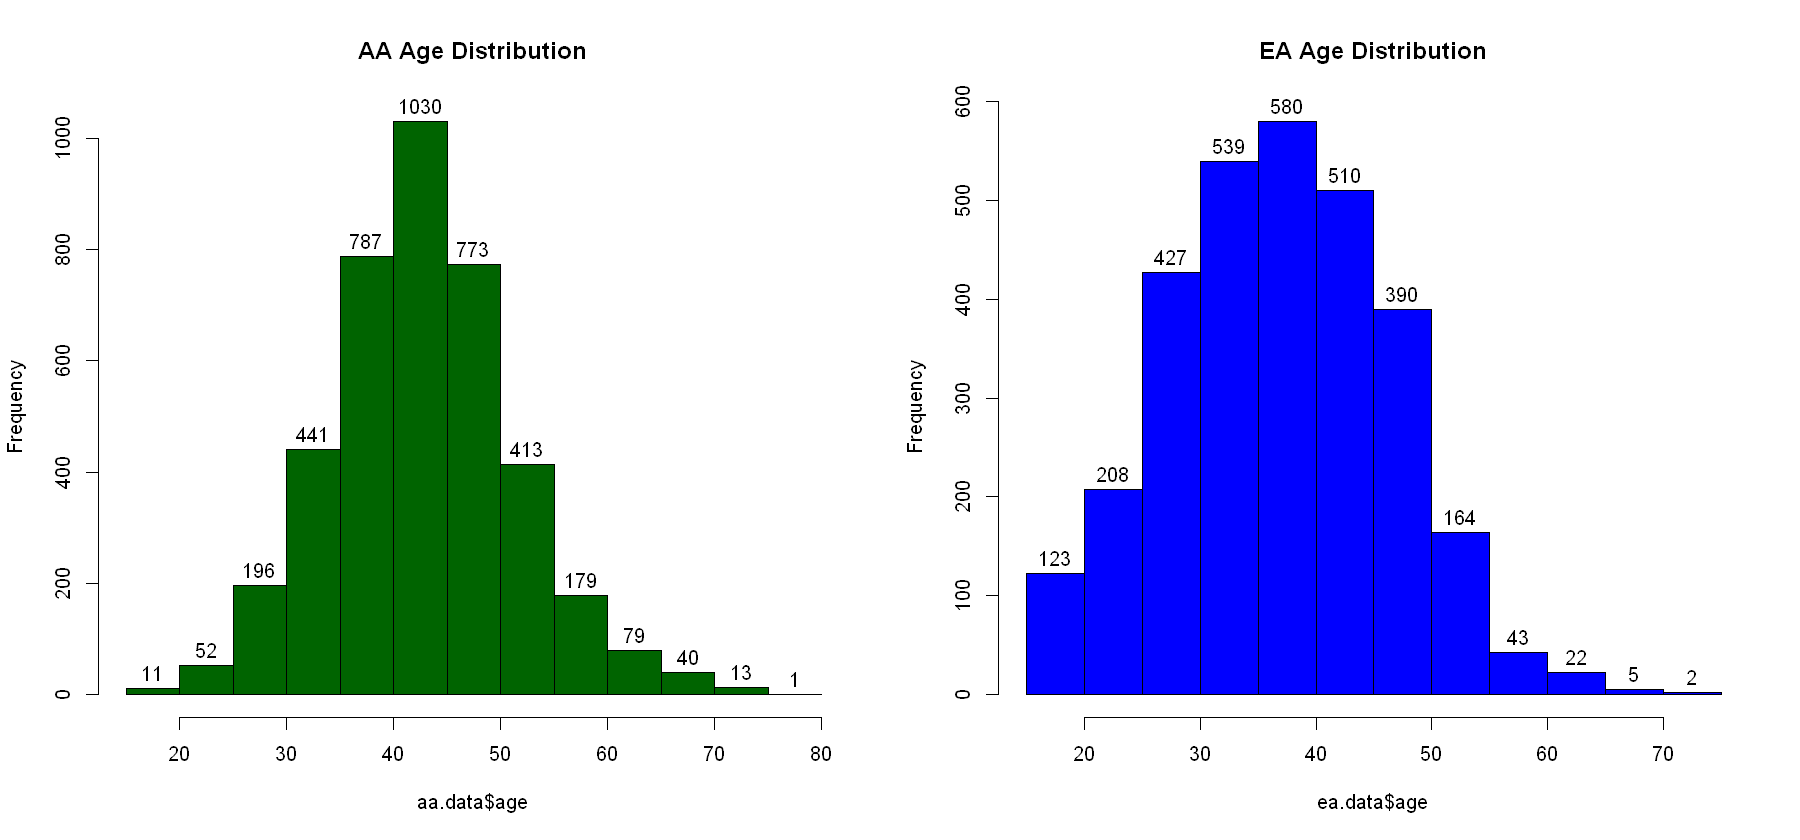

In [6]:
set_plot_dimensions <- function(width_choice, height_choice) {
        options(repr.plot.width=width_choice, repr.plot.height=height_choice)
    }
        
set_plot_dimensions(15,7)
par(mfrow=c(1,2))
hist(aa.data$age, col = "dark green", labels = T,
    main="AA Age Distribution")
hist(ea.data$age, col = "blue", labels = T,
    main="EA Age Distribution")

### PCA (EIGENSTRAT)
In the GWAS model, one should control from ancestry substructure. This is achieved by including the top genotype principal component as covariates in the GWAS statistical model. The software EIGENSTRAT can be used to perform the PCA. It is run on LD-pruned observed autosome genotypes for each ancestry group. 
#### Automated Pipeline

In [ ]:
#!/bin/bash

## Set global variables ##
anlist="ea aa" # "ea", "aa", or "ea aa"
study="uhs1234"
case_control="true"  # true if (case control phenotype) false if (not)
genoD="/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/observed" # observed genotype data
procD="/shared/jmarks/hiv/uhs1234/acquisition_gwas/test"  # processing directory
eig="$procD/eig" # do not alter
mkdir -p $eig/results

for an in $anlist;do
    ## rename phenotype file(s) to standard name ##
    current_pheno=$procD/uhs1234_${an}_phenotype_table_clean.txt # edit this line
    new_pheno=$procD/$study_${an}_phenotype_for_pca.txt # don't edit this line
    cp $current_pheno $new_pheno 

    
    ## generate new set of genotype data ##
    genotype_file="${an}_studies_merged" # edit this line
    awk 'NR>=2{print $1,$1}' \
        $current_pheno > $procD/$study.$an.final_ids

    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $genoD/$an/$genotype_file \
        --keep $procD/$study.$an.final_ids \
        --make-bed \
        --out $eig/$study.$an.genotypes

done

# Do not edit below this line
################################################################################
################################################################################


## Remove high-LD region variants ##
for an in $anlist; do
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
        $eig/$study.$an.genotypes.bim > $eig/$study.$an.genotypes.high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes \
        --exclude $eig/$study.$an.genotypes.high_ld_regions.remove \
        --make-bed \
        --out $eig/$study.$an.genotypes.high_ld_regions_removed
done


## Linkage disequilibrium pruning ##
for an in $anlist;do
    for chr in {1..22}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out $eig/${an}_chr${chr}_ld_pruned
    done
done

# Merge *prune.in files
for an in $anlist; do
    cat $eig/${an}_chr*_ld_pruned.prune.in > $eig/${an}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
        --extract $eig/${an}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/$study.$an.genotypes.ld_pruned
done

# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*ld_prune*qsub*
rm $eig/*high_ld_regions*
rm $eig/*nosex


## Rename BIM/FAM file IDs
for an in $anlist;do
    # Rename FAM file IDs
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.fam \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.fam

    # Rename BIM file IDs
    awk '{$2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.bim \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.bim
done

## Assign Case/Control to FAM file if applicable
if [ $case_control == "true" ]; then
    for an in $anlist; do
        pfile=$procD/$study_${an}_phenotype_for_pca.txt

        ## extract the IDs of controls
        tail -n +2 $pfile |\
            awk '{ if ($2==0) {print $1}}' > $eig/$an.controls.ids

        # Modify FAM file to include case/control status
        awk 'NR==FNR{map[$1] = $1; next} {if($2 in map) {$6=1} else {$6=2}} {print $0} ' \
            $eig/$an.controls.ids $eig/$study.$an.genotypes.ld_pruned_renamed.fam >\
            $eig/$study.$an.genotypes.ld_pruned_renamed_case_control.fam
    done
fi

## run eigenstrat ##
for an in $anlist; do
    if [ $case_control == "true" ]; then
        famfile="$eig/$study.$an.genotypes.ld_pruned_renamed_case_control.fam"
    else
        famfile="$eig/$study.$an.genotypes.ld_pruned_renamed.fam"
    fi
    bimfile="$eig/$study.$an.genotypes.ld_pruned_renamed.bim"
    bedfile="$eig/$study.$an.genotypes.ld_pruned.bed"

    /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i $bedfile \
        -a $bimfile \
        -b $famfile \
        -o $eig/results/${an}_ld_pruned.pca \
        -p $eig/results/${an}_ld_pruned.plot \
        -e $eig/results/${ancestry}_ld_pruned.eval \
        -l $eig/results/${ancestry}_ld_pruned.pca.log \
        -m 0
done

## Extract eigenvectors (top 10 PCs)
for an in $anlist; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${an}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
done


## Next produce PCA plots

#### View PCs from EIGENSTRAT
Copy results over to local machine.

In [ ]:
cd /cygdrive/c/Users/jmarks/Desktop/Projects/HIV/uhs1-4/phenotype/processing/eig
scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing/eig/results/*{evec,txt}

In [110]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/eig/")
options(stringsAsFactors = F)
ea.evec <- read.table("ea_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
aa.evec <- read.table("aa_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
head(ea.evec[,1:5])
head(aa.evec[,1:5])

,V2,V3,V4,V5,V6
ID_1:ID_1,0.0049,0.0022,0.0012,-0.0001,-0.0038
ID_2:ID_2,-0.0127,-0.0280,0.0069,-0.0061,0.0060
ID_3:ID_3,-0.0145,-0.0325,0.0053,-0.0017,-0.0016
ID_4:ID_4,0.0086,0.0034,-0.0009,-0.0022,-0.0033
ID_5:ID_5,0.0071,0.0063,-0.0008,0.0015,0.0010
ID_6:ID_6,-0.0020,-0.0177,-0.0013,0.0004,0.0000


,V2,V3,V4,V5,V6
ID_1:ID_1,0.0012,0.0039,-0.0072,-0.0016,-0.0006
ID_2:ID_2,-0.0140,0.0023,-0.0045,0.0006,0.0086
ID_3:ID_3,-0.0046,0.0004,-0.0009,-0.0030,0.0195
ID_4:ID_4,-0.0151,0.0026,-0.0084,0.0027,0.0042
ID_5:ID_5,-0.0148,0.0055,-0.0024,-0.0005,0.0023
ID_6:ID_6,0.0263,0.0022,-0.0005,-0.0045,-0.0051


In [1]:
### R console ###
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

## EA ##
#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 EA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 EA", cex.main=1)

## AA ##
#Run PCA and get % variance
aa.dspace <- aa.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 AA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 AA", cex.main=1)

ERROR: Error in eval(expr, envir, enclos): object 'ea.evec' not found


#### PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance. Make PED format phenotype and covariate file according to the NGC protocol.

##### Create ped file
The GWAS software tool accepts a phenotype file and a covariate file. We will create those files here and refer to them as ped and cov files.

In [114]:
create_pedfile <- function(phen_file, pca_file, phenotype, sex_var, covariates, study, ancestry){
    
    # phenotype file
    pheno_data <- read.delim(phen_file, sep="")
    pca_data <- read.delim(pca_file, sep="")
    other_pedcols <- c("fid", "iid", "patid", "matid", sex_var)
    ped_width <- length(other_pedcols) + length(phenotype)
    ped_length <- nrow(pheno_data)
    ped_file <- data.frame(matrix(ncol=ped_width, nrow=ped_length))
    colnames(ped_file) <- c(other_pedcols, phenotype)
    ped_file[phenotype] <- pheno_data[phenotype]
    ped_file[sex_var] <- pheno_data[sex_var]
    ped_file["fid"] <- pheno_data[1]
    ped_file["iid"] <- pheno_data[1]
    # covariate file
    num_cols <- 14 + length(covs)
    covar_data <- data.frame(matrix(ncol=num_cols, nrow=ped_length))
    colnames(covar_data) <- c("fid", "iid", "patid", "matid", covs,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    covar_data[,1:4] <- ped_file[, 1:4]
    for (i in covs){
        covar_data[,i] <- pheno_data[,i]
    }
    
    covar_data[, (num_cols-9):num_cols] <- pca_data[,3:12]
    write.table(ped_file, paste(study,"_", ancestry, "_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)
    write.table(covar_data, paste(study,"_", ancestry, "_cov.ped", sep=""), sep = "\t", row.names = F, quote=F)
    head(ped_file)
    #head(covar_data)
    
    } # end function

#### Regression analysis
We use a regression model of the general structure:

$Phenotype = PC1 + PC2 + ... + PC10$

In [115]:
regression_analysis <- function(cov_file, phen_file, phenotype_name, model_type, ancestry){
    options(stringsAsFactors=F)
    
    cov_data <- read.delim(cov_file, sep="")
    phen_data <- read.delim(phen_file, sep="")
    pc_names <- paste0("PC", 1:10)
    merge_data <- merge(x=phen_data[,c("iid", phenotype_name)], y=cov_data[, c("iid", pc_names)], by="iid")
    
    model.str <- paste0(phenotype_name, "~", paste(pc_names, collapse=" + ")) 
    cat("MODEL FORMULA:\n\n", model.str, "\n")
    
    # Get model fits
    if (model_type=="continuous"){
        model_fit <- lm(formula=as.formula(model.str), data=merge_data)
        pve_calc <- "Mean Sq"
    }
    else if (model_type=="logistic"){
        model_fit <- glm(formula=as.formula(model.str), data=merge_data, family=binomial(link="logit"))
        pve_calc <- "Deviance"
    }
    
    # Get sequential (type I) sum of squares
    anova_model <- anova(model_fit)
    
    # Calculate percent variance explained and sort
    variance_explained <- cbind(anova_model[pc_names,], 
                    PVE=round(anova_model[pc_names, pve_calc]/sum(anova_model[pc_names, pve_calc])*100, digits=2))
    pve_sorted <- variance_explained[order(variance_explained$PVE, decreasing=T),]
    
    # Output regression info
    cat(paste("\n\n================", ancestry,  "group ================\n"))
    summary(model_fit)
    pve_sorted
    
    # Percent Variance Explained Visualization
    options(repr.plot.width=13, repr.plot.height=5)

    # Set graphical parameters
    cex.factor <- 0.9
    barplot_ylim <- c(0, max(variance_explained$PVE)*1.2)

    pv_list <- vector(length = 10)
    total <- 0
    for (i in 1:nrow(pve_sorted)){
        pv_list[i] <- row.names(pve_sorted[i,])
        total <- total + pve_sorted[i, "PVE"]
        #print(total)
        if (total >= 75) break
    }

    topPCs <- pv_list[which(pv_list != "FALSE")]
    cat("Top PCs: ",topPCs, "\n")
    cat(paste("PVE:     ", total))

    # Visualize PVE
    par(mfrow=c(1,2))
    barplot(height=variance_explained$PVE, names.arg=rownames(variance_explained), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, 
            main=paste(ancestry,"Percent Variance Explained"), ylab="PVE")
    plot(cumsum(variance_explained$PVE), type="b", main=paste(ancestry, "PVE Cumulative Sum"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(variance_explained), cex.axis=cex.factor)

    par(mfrow=c(1,2))
    barplot(height=pve_sorted$PVE, names.arg=rownames(pve_sorted), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, main=paste(ancestry,"Percent Variance Explained (Sorted PCs)"), ylab="PVE")
    plot(cumsum(pve_sorted$PVE), type="b", main=paste(ancestry,"PVE Cumulative Sum (Sorted PCs)"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(pve_sorted), cex.axis=cex.factor)
}

##### AA

fid,iid,patid,matid,gender,hiv
109@1064714572,109@1064714572,NA,NA,1,0
202@1064714531,202@1064714531,NA,NA,0,0
312@1064714548,312@1064714548,NA,NA,1,0
378@1064610814,378@1064610814,NA,NA,1,0
432@1064714492,432@1064714492,NA,NA,1,0
456@1064714691,456@1064714691,NA,NA,1,0


MODEL FORMULA:

 hiv~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ AFR group ================
Top PCs:  PC10 PC9 PC2 PC6 
PVE:      81.81

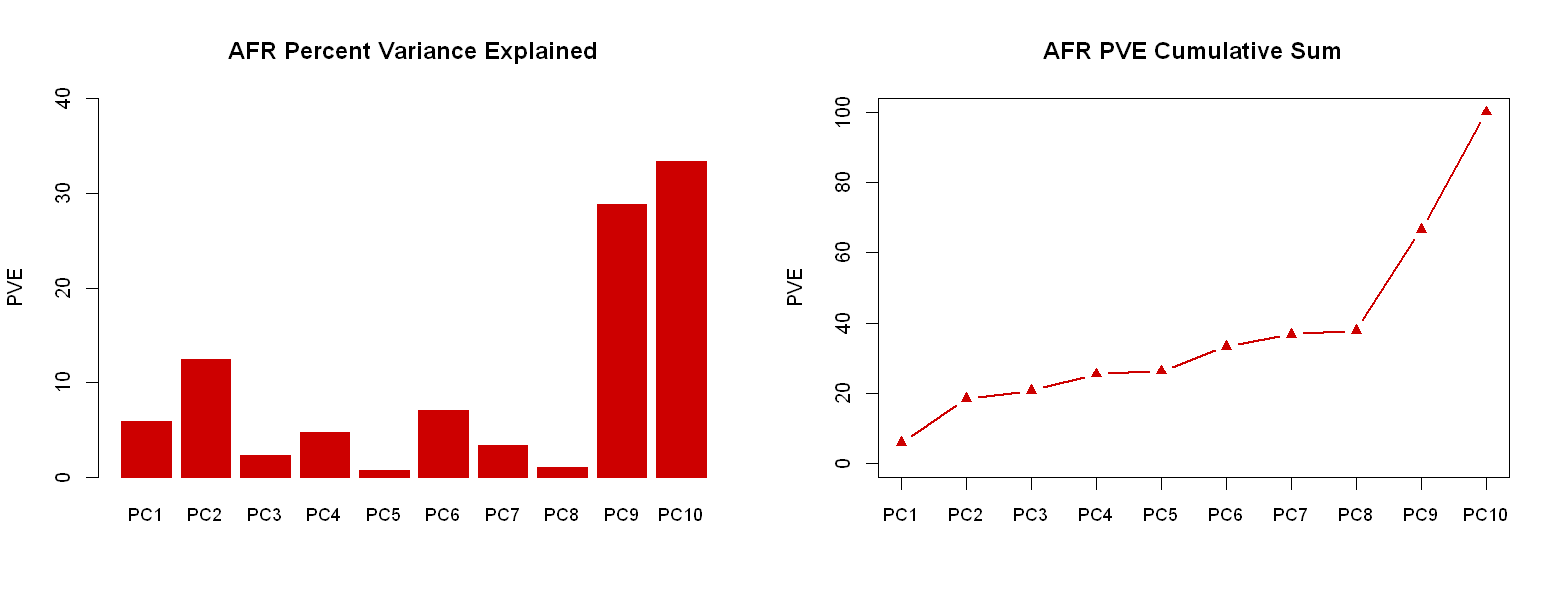

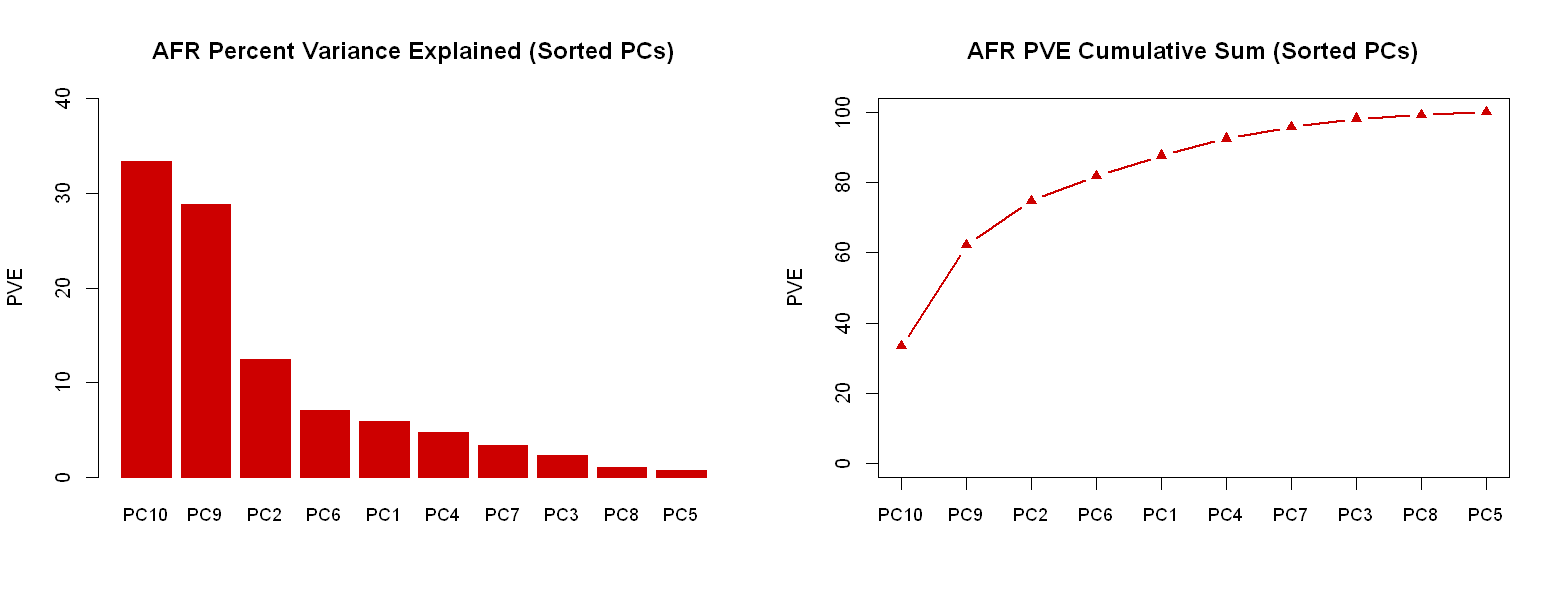

In [116]:
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/")
study <- "UHS1234"
ancestry <- "AFR" # EUR or AFR
phenotype <- "hiv"
sex_var <-  "gender"
covs <- c(sex_var, "age")
phen_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/uhs1234_aa_phenotype_table_clean.txt"
pca_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/eig/aa_ld_pruned_top10_eigenvecs.txt"
model_type <- "logistic" # continuous or logistic

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

##### EA

fid,iid,patid,matid,gender,hiv
260524@1054753970,260524@1054753970,NA,NA,0,0
245@1064714500,245@1064714500,NA,NA,1,0
266@1064714555,266@1064714555,NA,NA,1,0
441@1064714760,441@1064714760,NA,NA,1,0
541@1064714713,541@1064714713,NA,NA,1,0
564@1064612881,564@1064612881,NA,NA,0,0


MODEL FORMULA:

 hiv~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EUR group ================
Top PCs:  PC1 PC9 PC10 
PVE:      82.11

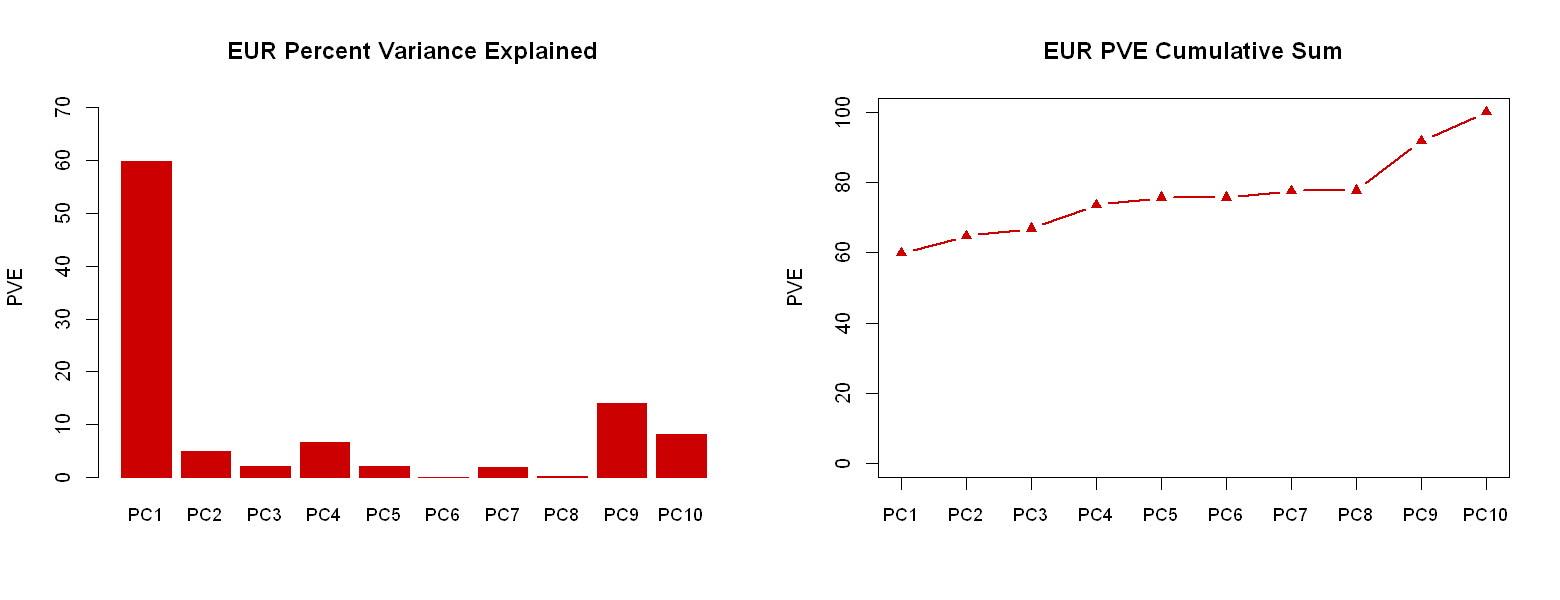

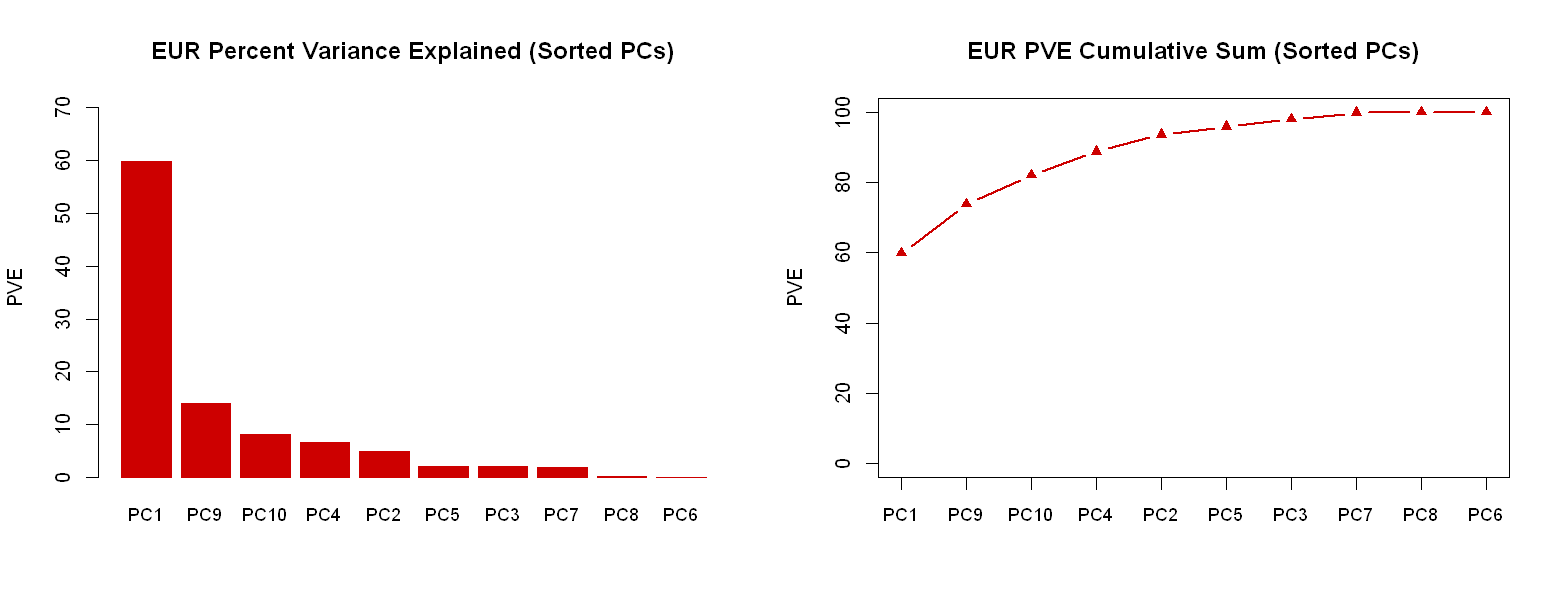

In [117]:
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/")
study <- "UHS1234"
ancestry <- "EUR" # EUR or AFR
phenotype <- "hiv"
sex_var <-  "gender"
covs <- c(sex_var, "age")
phen_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/uhs1234_ea_phenotype_table_clean.txt"
pca_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/phenotype/processing/eig/ea_ld_pruned_top10_eigenvecs.txt"
model_type <- "logistic" # continuous or logistic

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

### Alter iid to match imputed data
The IDs in the genotype (imputed data) are of the form `fid_iid`. Therefore, I need to map the iid in the PED files to this format.

In [ ]:
## Bash ##
study=UHS1234

# AA
awk '{OFS="_"} { print $2,$2 } ' ${study}_AFR_phen.ped > new_id
awk 'NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
    new_id ${study}_AFR_phen.ped > ${study}_NGCW1_AFR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
    new_id ${study}_AFR_cov.ped > ${study}_NGCW1_AFR_cov.ped


# EA
awk '{OFS="_"} { print $2,$2 } ' ${study}_EUR_phen.ped > new_id
awk 'NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
    new_id ${study}_EUR_phen.ped > ${study}_NGCW1_EUR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
    new_id ${study}_EUR_cov.ped > ${study}_NGCW1_EUR_cov.ped

scp -i ~/.ssh/gwas_rsa *NGCW1* ec2-user@34.206.166.72:/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/processing

### ProbABEL format for phenotype file
The format of the phenotype thus far has follows the protocol of the NGC protocol, and therefore the phenotype file format is prepared for RVTESTS. Since we are using the ProbABEL software for these analysis we will format the phenotype file to be of the  form:
```
IID    PHENOTYPE    OTHER_COVARIATES
```
where `OTHER_COVARIATES` could be sex, age, PCs, etc. 

**Note:**

**additional phenotype processing will have to be done once the genotype data are processed.** In particular, we will:
1. First get the IDs of the samples in the phenotype file.
2. Then we will filter the genotype (imputed) data down to those subjects in the phenotype file.
3. We will get the order of the subjects in the genotype data and then reorder our phenotype data to be the same order
    * this is more efficient than trying to reorder every genotype file.

Also take note about the coding of case/control status, as well as other binary variables in the phenotype file. The ProbABEL software dictates that the binary phenotype variable is to be coded as 0s & 1s, presumably control=0, case=1. We should code the sex variable to this standard as well.

In [ ]:
probabel_phenotype <- function(cov_file, pheno_file, study, pop, pcs, other_covs, pheno){
    #Convert your phenotype PED files (as required for rvtests) to the
    #ProbABEL format.
    
    pc_paste <- paste(pcs, collapse="+")
    othercov_paste <- paste(other_covs, collapse="_")
    out_name <- paste(study, pop, pheno, othercov_paste, pc_paste, sep="_")
    out_name <- paste0(out_name, ".txt")

    all_covs <- c(other_covs, pcs)

    # read in data files
    my_cov <- read.table(cov_file, header=T)
    my_pheno <- read.table(pheno_file, header=T)

    num.subjects <- length(my_cov[,1])

    # create new phenotype file (dataframe)
    num_cols = 2 + length(other_covs) # iid + pheno + covs
    covar.data <- data.frame(matrix(ncol = num_cols, nrow = num.subjects))
    names(covar.data) <- c("iid", pheno, other_covs)
    covar.data[1] <- my_pheno[,"iid"]
    covar.data[2] <- my_pheno[, pheno]

    for (cov in all_covs){
        covar.data[, cov] <- my_cov[,cov]
    }
    #head(covar.data)

    write.table(x = covar.data, file = out_name, quote = F, row.names = F)
    write.table(x = covar.data[,1], file = paste0("phenotype_ids_", pop), 
                quote = F, row.names = F, col.names=F)
}

#### EA and AA
Convert phenotype file for both EA and AA to probabel format

In [ ]:
### R ###
setwd("/shared/jmarks/hiv/uhs1234/acquisition_gwas/phenotype/final")

## AA
cov_file <- "../processing/UHS1234_NGCW1_AFR_cov.ped"
pheno_file <- "../processing/UHS1234_NGCW1_AFR_phen.ped"
study <- "uhs1234"
pop <- "aa"
pcs = c("PC10", "PC9", "PC2", "PC6")
other_covs <- c("age", "gender")
pheno <- "hiv"
probabel_phenotype(cov_file, pheno_file, study, pop, pcs, other_covs, pheno)


## EA
cov_file <- "../processing/UHS1234_NGCW1_EUR_cov.ped"
pheno_file <- "../processing/UHS1234_NGCW1_EUR_phen.ped"
study <- "uhs1234"
pop <- "ea"
pcs = c("PC1", "PC9", "PC10")
other_covs <- c("age", "gender")
pheno <- "hiv"
probabel_phenotype(cov_file, pheno_file, study, pop, pcs, other_covs, pheno)

## Genotype Processing and GWAS Pipeline
This is an automated pipeline for preparing the genotype data for a GWAS using the ProbABEL tool. The steps in this pipeline are:

1. Merge chrX
    * The chrX imputed data from the Michigan Imputation Server is split between males and females. We need to merge these data for the GWAS because the other data is not split by sex. We control for that with a sex covariate.
2. Convert imputed data format
    * The ProbABEL software requires the data to be formatted differently than the VCF format that is the output from MIS. In particular, we need to convert the VCF files (dosage) to MaCH format.
3. Prune imputed data
    * Prune the imputed data to only the subjects with phenotype data
4. Reorder phenotype file 
    * order the subjects in phenotype file to be the same order as the genotype data (takes less memory to reorder the phenotype file rather than all of the genotype files)
5. Create legend file
6. Reformat info file

<br>
<br>

**Note1:** that the genomic data need to be inflated after they have been download from the Michigan Imputation Server.

**Note2:** this pipeline will perform the actual GWAS (1df and 2df) as well. For the 2df analysis, you might have to adjust the `interaction` parameter in the ProbABEL command. The number you provide should be the number of columns to the right of the phenotype variable that the interaction variable is in your phenotype file. For example, the interaction variable is currently coded as 2 in this pipeline for the 2df GWAS. It is coded as a 2 because we are wanting to perform a GxSex analysis for the 2df GWAS and the sex variable `gender` is two columns to the right of the phenotype variable `hiv` in the phenotype file.

```
iid hiv age gender PC10 PC9 PC2 PC6
109@1064714572_109@1064714572 0 26 1 0.0011 0.0075 0.0039 -3e-04
202@1064714531_202@1064714531 0 27 0 0.0093 -0.0112 0.0023 0.0017
312@1064714548_312@1064714548 0 34 1 -0.0012 -0.0012 4e-04 0.0173
378@1064610814_378@1064610814 0 30 1 0.0113 0.0016 0.0026 0.0043
```

**Note3:** pay close attention to the variables above the double octothorpe line. Be sure to edit them accordingly, like for example the `ancestry, covars` and the `phenotype_file` variables. The `s3_upload` variable should be changed per study as well.

**Note4:** we recommend running the first set of functions first, and then when they finish go on to set number two. This is because the first set of functions do not require as much memory as the second set of functions. For the first set of functions, use a smaller compute node (e.g. the m5.large) and then use a memory intensive compute node (e.g. x1e.2xlarge).

**Note5:** compute the chromosomes in batches. For ProbABEL to run, one needs to decompress the chromosomes. This can create storage issues; chromosomes 2 decompressed for the UHS1234 AA group is 92GB! It is therefore advised to process just a few chromosomes at a time so as not to run into storage issues. 

In [ ]:
## bash script ##
chr=$1  # command line argument (chromosome number)

ancestry="ea"
covars="sex,age,PC1,PC9,PC10"  # comma separated
study="uhs1234"
version="001"  # gwas attempt/version (e.g. 001)
probabel="palogist" # palogist (logistic) or palinear (linear)

baseD=/shared/jmarks/hiv/uhs1234/acquisition_gwas
imputeD=$baseD/genotype/imputed/$ancestry
phenD=$baseD/phenotype/final
procD=$baseD/gwas/1df/$ancestry/$version # output of 1df test and log files
procD2=$baseD/gwas/2df/$ancestry/$version # output for 2df test

phenotype_file=$phenD/uhs1234_ea_hiv_age_gender_PC1+PC9+PC10.txt
pheno_order=$phenD/phenotype_ids_${ancestry} # list of ids extracted from the phenotype file 

# path to the order of the subject IDs in the pruned genotype files 
# (output from reording genotype files with python script)
id_order=$baseD/genotype/imputed/$ancestry/mach/chr$chr/chr$chr.genotype.id.order  

# where to upload the genotype data after GWAS are complete 
s3_upload=s3://rti-hiv/hiv_uhs1234/data/genotype/imputed/$ancestry/output/gwas_processed/chr$chr/

if [ $ancestry == "aa" ]; then
    group=afr
elif [ $ancestry == "ea" ]; then
    group=eur
fi

# prepare directory structure
for dir in 1df 2df; do
    mkdir -p $procD/final
    mkdir -p $procD/processing/chr{1..23}
    mkdir -p $procD2/final
    mkdir -p $procD2/processing/chr{1..23}

done


# Don't edit below this line
####################################################################################################
####################################################################################################
main() {
    echo -e "\n\nHello, initializing the ProbABEL GWAS pipeline."
    
    ## SET1: These functions can be run with smaller compute nodes (m5.large)
    merge_chrx 
    convert_chrx 
    convert_auto 
    create_legend 
    format_info
    prune_geno $chr $imputeD/mach/chr$chr $pheno_order

    ## SET2: Run the functions below with larger memory compute nodes (x1e.2xlarge)
    #gwas_1df          
    #gwas_2df
    #status_check "yes"  # "yes" (zip data and upload to S3) or "no" (don't zip/upload data)
}
####################################################################################################
####################################################################################################

# merge chrx male & female data
merge_chrx() {
    echo -e "\n\n\n################################################################################"
    echo -e "START: merge_chrx() function for chr$chr"
    echo -e "################################################################################"

    if [ $chr == 23 ]; then
        echo "Merging chrx for males & females..."

        /shared/bioinformatics/software/third_party/bcftools-1.6/bcftools merge \
            $imputeD/chrX.no.auto_male.dose.vcf.gz $imputeD/chrX.no.auto_female.dose.vcf.gz \
            -O z -o $imputeD/chrX.no.auto.dose.vcf.gz
    else
        echo "chr$chr is an autosome. Exiting merge_chrx() function."
    fi
    
    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: merge_chrx() function for chr$chr\n\n\n\n"
}

# convert chrx data to ProbABEL acceptable format
convert_chrx() {

    echo -e "\n\n\n################################################################################"
    echo "START: convert_chrx() function for chr$chr"
    echo -e "################################################################################\n"
    echo "Converting chrx data to ProbABEL acceptable format...\n"

    if [ $chr == 23 ]; then
        chr_location=$imputeD/mach/chr${chr}
        mkdir -p $chr_location
        /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
            --vcfDose $imputeD/chrX.no.auto.dose.vcf.gz \
            --prefix ${chr_location}/chr${chr} \
            --type mach \
            --format 1 # contains the expected alternate allele count (one value per sample per marker).
    else
        echo "chr$chr is an autosome. Exiting convert_chrx() function."
    fi

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: convert_chrx() function for chr$chr\n\n\n\n"
}



# convert autosomal data to ProbABEL acceptable format
convert_auto() {
    echo -e "\n\n\n################################################################################"
    echo "START: convert_auto() function for chr$chr"
    echo -e "################################################################################\n"

    chr_location=$imputeD/mach/chr$chr
    mkdir -p $chr_location
    /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
        --vcfDose $imputeD/chr$chr.dose.vcf.gz \
        --info $imputeD/chr$chr.info.gz \
        --prefix $chr_location/chr$chr \
        --type mach \
        --format 1 # contains the expected alternate allele count (one value per sample per marker).
    
    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: convert_auto() function for chr$chr\n\n\n\n"
}


# create legend file for ProbABEL
create_legend() {
    echo -e "\n\n\n################################################################################"
    echo "START: create_legend() function for chr$chr"
    echo -e "################################################################################\n"

    # HapMap "legend" file format
    # note that our data is not in rsID format - we have chr:position for the rsID instead
    echo "Creating the legend file for ProbABEL input."
    echo "id position 0 1" > $imputeD/mach/chr$chr/map.chr$chr.legend
    # grab the SNP, position, allele1 and allele2
    tail -n +2 $imputeD/mach/chr$chr/*info |\
    awk '{pos = $1; gsub(/^.+:/, "", pos); print $1,pos,$2,$3}' >>\
    $imputeD/mach/chr$chr/map.chr$chr.legend

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: create_legend() function for chr$chr\n\n\n\n"
}



# format the info file for ProbABEL
format_info() {
    echo -e "\n\n\n################################################################################"
    echo "START: format_info() function for chr$chr"
    echo -e "################################################################################\n"
    echo "Pruning down the info file to be compliant with ProbABEL."
    cut -f 1-7 $imputeD/mach/chr${chr}/chr${chr}.mach.info >\
        $imputeD/mach/chr$chr/chr$chr.mach.info.pruned  \

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: format_info() function  for chr$chr\n\n\n\n"
}



# prune the genotype data
prune_geno() {
    echo -e "\n\n\n################################################################################"
    echo "START: prune_geno() function for chr$chr"
    echo -e "################################################################################\n"

    baseD=$2
    idL=$3
    time python ~/bin/prune_genotype_files.py $chr $baseD $idL

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: prune_geno() function for chr$chr\n\n\n\n"
}


## perform 1df GWAS (logistic)
gwas_1df() {
    echo -e "\n\n\n################################################################################"
    echo "START: gwas_1df() function for chr$chr"
    echo -e "################################################################################\n"
    echo "First, reorder the phenotype file so that the subject IDs are in the same order as the genotype data..."

    if [ $chr == 23 ]; then
        phenoF=${phenotype_file::-4}_ordered_chrx.txt
    else
        phenoF=${phenotype_file::-4}_ordered.txt
    fi

    # check to see if file has already been created
    if [ -e $phenoF ]; then
        echo -e "\t...The phenotype file: $phenoF already exists. Now on to the 1df GWAS.\n"
    else
        head -1 $phenotype_file > $phenoF
        awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
            $phenotype_file $id_order >> $phenoF
        echo -e "Phenotype file: $phenoF has now been created. On to the 1df GWAS.\n"
    fi

    /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
        --pheno $phenoF \
        --dose  $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned \
        --info  $imputeD/mach/chr$chr/chr$chr.mach.info.pruned \
        --map   $imputeD/mach/chr$chr/map.chr$chr.legend \
        --chrom $chr \
        --out   $procD/processing/chr$chr/chr$chr.$probabel.results

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: gwas_1df() function for chr$chr\n\n\n\n"
}


## perform 2df GWAS (logistic)
gwas_2df() {
    echo -e "\n\n\n################################################################################"
    echo "START gwas_2df() function for chr$chr"
    echo -e "################################################################################\n"
    echo "First, reorder the phenotype file so that the subject IDs are in the same order as the genotype data."

    if [ $chr == 23 ]; then
        phenoF=${phenotype_file::-4}_ordered_chrx.txt
    else
        phenoF=${phenotype_file::-4}_ordered.txt
    fi

    # check to see if file has already been created
    if [ -e $phenoF ]; then
        echo -e "The phenotype file: $phenoF already exists. Now on to the 2df GWAS. \n"
    else
        head -1 $phenotype_file > $phenoF
        awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
            $phenotype_file $id_order >> $phenoF
        echo -e "Phenotype file: $phenoF has now been created. On to the 2df GWAS.\n"
    fi

    /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
        --pheno $phenoF \
        --dose  $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned \
        --info  $imputeD/mach/chr$chr/chr$chr.mach.info.pruned \
        --map   $imputeD/mach/chr$chr/map.chr$chr.legend \
        --chrom $chr \
        --interaction 2 \
        --out   $procD2/processing/chr$chr/chr$chr.$probabel.results 

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: gwas_2df() function for chr$chr\n\n\n\n"
}


## Determine if GWAS was completed and gzip imputed genetic data ##
status_check() {
    echo -e "\n\n\n################################################################################"
    echo "START: status_check() function for chr$chr"
    echo -e "################################################################################\n"


    myzip=$1 # should be yes or no
    
    # if there are two 100.00% then both GWAS finished
    stat="$(grep  100.00% $procD/processing/chr$chr/*log | wc -l)"
    
    if [ $stat == "2" ]; then
        echo "GWAS COMPLETE!!"
        echo "Both 1df and 2df GWAS are complete for chr$chr."

        if [ $myzip == "yes" ]; then
            echo -e "Attempting to gzip genotype file..."

            if [ -e $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned ]; then
                echo "Zipping genotype file..."
                gzip $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned
                echo -e "Gzip was successful.\n\n"
                echo -e "Uploading $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned.gz $to $s3_upload...\n"
                aws s3 sync $imputeD/mach/chr$chr $s3_upload 
                echo -e "\nUpload complete.\n"
            else
                echo "The file $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned does not exist."
                if [ -e $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned.gz ]; then
                    echo "This file has already been gzipped."
                    echo -e "Uploading $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned.gz $to $s3_upload...\n"
                    aws s3 sync $imputeD/mach/chr$chr $s3_upload 
                    echo -e "\nUpload complete."
                fi
            fi
        else
           echo "You have chosen not to zip & upload. Exiting now. Thank you, have a nice day! "    
        fi
    else
        echo "WARNING: The 1df and/or 2df GWAS may not have finished for chr$chr."
        echo "Please check log file: $procD/processing/chr$chr/*log"
    fi

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: status_check() function for chr$chr\n"
}

####################################################################################################
####################################################################################################
time main $1  # $1 is chromosome, 


# Start ProbABEL Analysis (logistic model)
Perform GWAS. Consult [ProbABEL manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) for details about software parameters. 


| Ancestry | cases | controls | Total |
|----------|-------|----------|-------|
| EUR      |  348  | 2,665    | 3,013 |
| AFR      |  627  | 3,388    | 4,015 |   



<br>
<br>
<br>
  
## How to run pipeline
**Note on performing the GWAS:**
```
The ProbABEL software requires the genotype data to be decompressed so that it requires a lot of storage. For this reason, it is best to run only portions of the genome at a time. An advisable way to run the pipeline above is as follows:

1. Convert all of the genetic data to the correct format by running the functions:
    -merge_chrx  
    -convert_chrx 
    -convert_auto 
    -create_legend 
    -format_info
   
        Comment out the functions:
            -prune_geno
            -gwas_1df          
            -gwas_2df
            -status_check 
            
2. Prune the genotype data to match the phenotype file with:
    -prune_geno
    
        Comment out the functions:
            -merge_chrx  
            -convert_chrx 
            -convert_auto 
            -create_legend 
            -format_info
            -gwas_1df          
            -gwas_2df
            -status_check 
            
3. Perform the 1df & 2df GWAS and then gzip the genotype data afterwards:
    -gwas_1df          
    -gwas_2df
    -status_check 
            
        Comment out the functions:
            -merge_chrx  
            -convert_chrx 
            -convert_auto 
            -create_legend 
            -format_info
            -prune_geno
```

Perform step 1 for all of the chromosomes. Then perform step 2 & 3 with just a couple or three chromosomes at a time. For step 1 and 2, use a smaller (and less expensive) compute node like the m5.large. When performing (3)—the ProbABEL 1df & 2df GWAS—one will have to use a compute node with very large memory (e.g. x1e.2xlarge). See below for example of how much memory just one chromosome is using for a 1df GWAS.

```
HOSTNAME                ARCH         NCPU NSOC NCOR NTHR  LOAD  MEMTOT  MEMUSE  SWAPTO  SWAPUS
----------------------------------------------------------------------------------------------
ip-172-31-22-183        lx-amd64        8    1    4    8  1.24  240.1G  211.4G     0.0     0.0
```

## AA GWAS
genotype PCs: PC10+PC9+PC2+PC6

**baseline (1df)**
```
Actual number of people in phenofile = 4015; using all of these
Logistic model: ( hiv ) ~ mu + age + gender + PC10 + PC9 + PC2 + PC6 + SNP_A1
```

**G$\times$Sex (2df)**
```
Actual number of people in phenofile = 4015; using all of these
Logistic model: ( hiv ) ~ mu + age + gender + PC10 + PC9 + PC2 + PC6 + SNP_A1 + gender*SNP_A1
```

<br>

Below is an simple script used to submit the GWAS script to the jobs scheduler.

In [ ]:
## submit the above script as a job ##
ancestry=aa
version=001
running_gwas=false  # true of false

# where the log file will output
procD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/$ancestry/$version

# if not running the GWAS then one should use smaller compute nodes
if [ $running_gwas == "false" ]; then
    mem=5
    slots=2
else
    mem=30
    slots=7
fi

# process data up to (not including) prune_geno() function
for chr in {1..23}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr$chr.$ancestry.probabel.gwas \
        --script_prefix $procD/processing/chr${chr}/chr${chr}_gwas \
        --mem $mem \
        --nslots $slots \
        --program bash _methods_hiv_acquisition_uhs1234_gwas_pipeline_${ancestry}_20190611.sh $chr
done

## EA GWAS
genotype PCs: PC1+PC9+PC10

**baseline (1df)**
```
Actual number of people in phenofile = 3013; using all of these
Logistic model: ( hiv ) ~ mu + age + gender + PC1 + PC9 + PC10 + SNP_A1
```

**G$\times$Sex (2df)**
```
Actual number of people in phenofile = 3013; using all of these
Logistic model: ( hiv ) ~ mu + age + gender + PC1 + PC9 + PC10 + SNP_A1 + gender*SNP_A1
```

<br>

Below is an simple script used to submit the GWAS script to the jobs scheduler.

In [ ]:
## Perform 1df & 2df GWAS with code below for chr7, chr8, and chr9 ##

ancestry=ea
version=001
running_gwas=true  # true of false

# where the log file will output
procD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/1df/$ancestry/$version

if [ $running_gwas == "false" ]; then
    job="processing.$ancestry"
    mem=5
    slots=2
else
    job="gwas.$ancestry"
    mem=30
    slots=7
fi

for chr in {7..9}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr$chr.$job \
        --script_prefix $procD/processing/chr${chr}/chr${chr}_gwas \
        --mem $mem \
        --nslots $slots \
        --program bash _methods_hiv_acquisition_uhs1234_gwas_pipeline_${ancestry}_20190611.sh $chr
done

# Results Processing
1. Calculate chi, P, and OR
2. Calculate chrX MAF
3. Convert variant name to 1KG phase 3 format
4. Filter results
    * MAF in study (keep >= 0.01)
    * MAF in 1KG (keep >= 0.01)
    * RSQ (keep with rsq >= 0.3) 
5. Plot results

In [ ]:
### bash script ###
chr=$1

ancestry="ea"
study="uhs1234"
phenotype="hiv_acq"
version=001
degree_free="2df"
cmax=23 # number of chromosomes (22 or 23)
probabel=palogist


baseD=/shared/jmarks/hiv/uhs1234/acquisition_gwas
procD=$baseD/gwas/$degree_free/$ancestry/$version/processing
phenD=$baseD/phenotype/final   # phenotype directory

# path to chrX info file for males and females (including file name)
maleInfo=$baseD/genotype/imputed/$ancestry/chrX.no.auto_male.info.gz 
femaleInfo=$baseD/genotype/imputed/$ancestry/chrX.no.auto_female.info.gz 

if [ $ancestry == "aa" ]; then
    group=afr
    phenoXF=uhs1234_aa_hiv_age_gender_PC10+PC9+PC2+PC6_ordered_chrx.txt  # name of chromosome X phenotype file

    if [ $degree_free == "1df" ];then
        MODEL=HIV_ACQ~SNP+AGE+SEX+PC10+PC9+PC2+PC6  # for 1df
    else
        MODEL=HIV_ACQ~SNP+AGE+SEX+SNPbySEX+PC10+PC9+PC2+PC6  # for 2df
    fi
        
elif [ $ancestry == "ea" ]; then
    group=eur
    phenoXF=uhs1234_ea_hiv_age_gender_PC1+PC9+PC10_ordered_chrx.txt  # name of chromosome X phenotype file

    if [ $degree_free == "1df" ];then
        MODEL=HIV_ACQ~SNP+AGE+SEX+PC1+PC9+PC10  # for 1df
    else
        MODEL=HIV_ACQ~SNP+AGE+SEX+SNPbySEX+PC1+PC9+PC10  # for 2df
    fi
fi
####################################################################################################
####################################################################################################
main() {
    echo -e "Results Processing\n\n"

    #calc_pvalue
    #chrx_maf
    #autosomes_1kg 
    #chrx_1kg
    #maf_study
    #maf_1kg
    #rsq
    plot_results
    pvalue_filter
}
####################################################################################################
####################################################################################################

## Calculate chi^2, Pvalue, and odds ratio ## 
calc_pvalue() {
    echo -e "\n################################################################################"
    echo  "START: calc_pvalue() function"
    echo -e "################################################################################\n\n"

    echo "$degree_free p-value calculation for $study $ancestry chr$chr..."
    if [ $degree_free == "1df" ]; then
        Rscript ~/bin/calculate_stats_for_probabel_results.R \
            --in_file $procD/chr$chr/chr$chr.$probabel.results_add.out.txt \
            --out_file $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats \
            --complete
    else

        Rscript ~/bin/calculate_2df_stats_from_probabel_results.R \
            --in $procD/chr$chr/chr$chr.$probabel.results_add.out.txt \
            --out $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats \
            --interaction_covar gender

        echo -e "Wrote to: $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats"
    fi
        
    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: calc_pvalue() function\n\n"
}

chrx_maf() {
    
    echo -e "\n\n################################################################################"
    echo -e "START: chrx_maf()"
    echo -e "################################################################################\n"

    if [ $chr == 23 ]; then
    
        ## calculate chrX MAF ##
        chrxD=$procD/chr23

        # count number of males and females (need this for new MAF calculation)
        femaleN=$(awk '$4==1' $phenD/$phenoXF | wc -l)
        maleN=$(awk '$4==0' $phenD/$phenoXF | wc -l)

        echo "Number of females: $femaleN"
        echo -e "Number of males: $maleN\n"

        # calculate new MAF by recalculating the combined sex specific stats (first get overlapping SNPs)
        cut -f1 <(zcat $femaleInfo | tail -n +2) | sort >\
           $chrxD/female_snps.txt 
        cut -f1 <(zcat $maleInfo | tail -n +2) | sort >\
           $chrxD/male_snps.txt 
        comm -12 $chrxD/male_snps.txt $chrxD/female_snps.txt >\
            $chrxD/male_female_snp_intersection.txt

        echo -e "Number of female SNPs: $(wc -l $chrxD/female_snps.txt)"
        echo -e "Number of male SNPs: $(wc -l $chrxD/male_snps.txt)\n"

        # filter info file down to the intersection set of SNPs (should be a large intersection)
        zcat $femaleInfo | head -1 > $chrxD/female_intersection_info.txt
        zcat $maleInfo| head -1  > $chrxD/male_intersection_info.txt

        # new female info file
        awk 'NR==FNR{map[$1]=$1; next} { if ($1 in map) {print $0} }' \
            $chrxD/male_female_snp_intersection.txt <(zcat $femaleInfo) >>\
            $chrxD/female_intersection_info.txt
        # new male info file
        awk 'NR==FNR{map[$1]=$1; next} { if ($1 in map) {print $0} }' \
            $chrxD/male_female_snp_intersection.txt <(zcat $maleInfo) >>\
            $chrxD/male_intersection_info.txt

        # Calculate new merged MAF
        awk -v fN=$femaleN -v mN=$maleN 'NR==FNR{female[$1] = $5; next} 
            FNR>=2{$5 = ( female[$1]*fN + $5*mN ) / (fN + mN)}
            {print $0}' $chrxD/female_intersection_info.txt\
            $chrxD/male_intersection_info.txt >\
            $chrxD/merged_male_female.info

        # insert recalculated MAF into stats file and filter to intersection
        head -1 $chrxD/$study.$ancestry.$degree_free.1000G_p3.chr23.$MODEL.stats >\
              $chrxD/$study.$ancestry.$degree_free.1000G_p3.chr23.$MODEL.recalc_maf.stats
              
        awk 'FNR==NR{map[$1]=$5; next} 
            { if ($1 in map) 
            {$7= map[$1]; print $0 } }'  $chrxD/merged_male_female.info \
            $chrxD/$study.$ancestry.$degree_free.1000G_p3.chr23.$MODEL.stats >>\
            $chrxD/$study.$ancestry.$degree_free.1000G_p3.chr23.$MODEL.recalc_maf.stats

        rm $chrxD/male_snps.txt
        rm $chrxD/female_snps.txt
        rm $chrxD/male_female_snp_intersection.txt
        rm $chrxD/female_intersection_info.txt
        rm $chrxD/male_intersection_info.txt
        rm $chrxD/merged_male_female.info
    else
        echo -e "WARNING: This is an autosome (not chrX). Exiting now.\n"
    fi


    echo -e "--------------------------------------------------------------------------------"
    echo -e "END: chrx_maf() function\n\n"
}

              
## convert SNP names to 1KG_p3
autosomes_1kg() {
    echo -e "\n\n################################################################################"
    echo -e "START: autosomes_1kg() function"
    echo -e "################################################################################\n"
    echo -e "Converting the SNP names to 1000 Genomes Phase 3 format (rsID:position:A1:A2).\n\n"

    if [ $chr -lt 23 ]; then
        if [ -e $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats ]; then
            perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
                --file_in $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats \
                --file_out $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats.converted \
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
                --file_in_header 1 \
                --file_in_id_col  0 \
                --file_in_chr_col  1 \
                --file_in_pos_col  2 \
                --file_in_a1_col  3 \
                --file_in_a2_col  4 \
                --chr $chr
        else
            echo "File $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats does not exist."
        fi
    else
        echo "WARNING: chr$chr is not an autosome. Exiting"
    fi

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: autosomes_1kg() function.\n\n"
}

chrx_1kg() {
    
    echo -e "\n\n################################################################################"
    echo -e "START: chrx_1kg() function"
    echo -e "################################################################################\n"
    echo -e "Converting the SNP names to 1000 Genomes Phase 3 format (rsID:position:A1:A2).\n\n"

    if [ $chr == 23 ]; then
        if [ -e $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.recalc_maf.stats ]; then
            perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
                --file_in $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.recalc_maf.stats \
                --file_out $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats.converted \
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
                --file_in_header 1 \
                --file_in_id_col  0 \
                --file_in_chr_col  1 \
                --file_in_pos_col  2 \
                --file_in_a1_col  3 \
                --file_in_a2_col  4 \
                --chr $chr 
        else
            echo "The file $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.recalc_maf.stats does not exist. Exiting."
        fi
    else
        echo -e "WARNING: chr$chr is not chrX. Exiting"
    fi
    
    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: chrx_1kg() function.\n\n"
}

# Remove variants with MAF <= 0.01 in the study data
maf_study() {
        
        echo -e "\n\n################################################################################"
        echo -e "START: maf_study() function."
        echo -e "################################################################################\n"
        echo -e "Removing variants with MAF <= 0.01 in the study data."

        echo "Processing chr${chr}_${ancestry} for MAF (study) filtering."
        head -n 1 $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats.converted > \
            $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats

        # note column 7 corresponds to the MAF column 
        awk ' NR>=2 {if ($7 >= 0.01) {print $0}}' \
            $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats.converted \
            >> $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats

        echo -e "\n--------------------------------------------------------------------------------"
        echo -e "END: maf_study() function.\n\n"
}
              
              
# Remove variants with MAF <= 0.01 in the 1KG data
maf_1kg() {

    echo -e "\n\n################################################################################"
    echo -e "START: maf_1kg() function."
    echo -e "################################################################################\n"
    echo -e "Removing variants with MAF <= 0.01 in the 1000 Genomes data."

    # creating a list of SNPs based off of 1000G population 
    # filter the variants to ones whose MAF <= 1%
    if [ $chr -lt 23 ]; then 
       awk ' { if ($9 >= 0.01) {print $1}}' \
       <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz) >\
        /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}

    # chrX
    elif [ $chr -eq 23 ]; then
        awk ' { if ($9 >= 0.01) {print $1}}' \
            <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz) >\
            /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}
    else
        echo "ERROR: chr$chr is an invalid entry. Exiting"

    fi

    idList=/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group} 
    echo "Processing chr${chr}_${ancestry}"      
    /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
        --source $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats \
        --id_list $idList \
        --out $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats \
        --header 1 \
        --id_column 0 

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: maf_1kg() function.\n\n"
}
              
            
## Remove SNPs with poor imputation quality (r^2 <= 0.30)
rsq() {
    echo -e "\n\n################################################################################"
    echo -e "START: rsq() function"
    echo -e "################################################################################\n"
    echo -e "Removing variants with poor imputation quality (r^2 <= 0.30).\n"
    
    # autosomes
    if [ $chr -lt 23 ]; then
        echo "Processing $ancestry chr$chr..."
        awk 'FNR==1 {print $0} FNR>=2{ if ($9 > 0.3){ print $0 } }' \
            $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats >\
             $procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
    
    # chrX
    elif [ $chr -eq 23 ]; then

    # chrX imputed data are split up by males & females 
    # perform the filtering on both male and female data and then merge results
        echo -e "Processing ${ancestry} chrX..."

        # male variants passing rsq filter
        tail -n +2 <(zcat $maleInfo) | \
            awk '{ if( $7 > 0.3){ print $1":"$2":"$3 } }' \
            > $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp

        # female variants passing rsq filter
        tail -n +2 <(zcat $femaleInfo) | \
            awk '{ if( $7 > 0.3){ print $1":"$2":"$3 } }' \
            >> $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp

        # keep only SNPs that passed filters for both males and females
        sort $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp |\
            uniq -d > $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep 

        # change X to 23 to be compliant with our plotting script  
        awk -F":" '$1=23 {print $0}' $procD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep >\
            $procD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep.split

        # filter results
        awk ' NR==FNR { map[$1":"$2":"$3":"$4] = 1; next}
            FNR==1 {print $0}
            FNR>=2 {if  (map[$2":"$3":"$4":"$5] == 1)
            { print $0} }' $procD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep.split \
            $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats >\
            $procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats

        rm $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp
        rm $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep
        rm $procD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep.split

    # exit function if a valid chromosome was not supplied as input.
    else
        echo "ERROR:  chr$chr is an invalid entry. Please enter a chromosome number {1..23}. Exiting"
    fi

    echo -e "Done"
    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: rsq() function.\n\n"

}
              
              
## Make Q-Q and manhattan plots ##
plot_results() {

    echo -e "\n\n################################################################################"
    echo -e "START: plot_results() function"
    echo -e "#################################################################################\n"
    echo -e "Creating the Manhattan and QQ plots.\n\n"

    if [ $degree_free == "1df" ];then
        skip_cols=10   # 1df
    else
        skip_cols=13   # 2df
    fi
    
    # create table of SNPs and corresponding pvalues, etc
    outfile=$procD/${study}.${ancestry}.1000G_p3.${phenotype}.maf_gt_0.01.rsq_gt_0.3.assoc.table
    echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile

    for ((chr=1; chr<=$cmax; chr++));do
        infile=$procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
        echo Processing $infile
        tail -n +2 $infile |
          perl -slne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){$myvar}\s+(\S+)/;
                      if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                        print join("\t",$1,$2,$3,$6,"snp");
                      } else {
                        print join("\t",$1,$2,$3,$6,"indel");
                      }' -- -myvar=$skip_cols >> $outfile
    done 

    Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $outfile \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $procD/../final/$study.${ancestry}.$degree_free.1000G.${phenotype}.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda  > $procD/$study.${ancestry}.$degree_free.1000G.${phenotype}.maf_gt_0.01.rsq_gt_0.3.assoc.plot 2>&1

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: plot_results() function.\n\n"
}
              
              
    
# filter to top SNPs (p <= 0.0001)
pvalue_filter() {

    echo -e "\n\n################################################################################"
    echo -e "START: pvalue_filter() function."
    echo -e "################################################################################\n\n"
    echo -e "Filtering the results to only the most signifanct SNPs (pvalue <= 0.0001).\n\n"

    if [ $degree_free == "1df" ];then
        pcol=15   # 1df
    else
        pcol=18   # 2df
    fi

    outFile=$procD/../final/$study.$ancestry.$degree_free.1000G_p3.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.p_lte_0.001
    

    head -n 1 $procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr22.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats > $outFile
    for ((chr=1; chr<=$cmax; chr++));do
            echo "Processing $procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats"
            tail -n +2 $procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats |\
            perl -slane 'if ($F[$pcol] <= 0.001) { print; }' -- -pcol=$pcol >>  $outFile
    done

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: pvalue_filter() function.\n"
}

##################################################################################
time main

In [ ]:
ancestry=ea
baseD=/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/1df/$ancestry/001/processing

for chr in {1..22};do
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr$chr.$ancestry.gwas.results.processing\
        --script_prefix $baseD/chr$chr/chr$chr.results.processing \
        --mem 5 \
        --nslots 2 \
        --priority 0 \
        --program bash results_processing_ea_v02.sh $chr
done

### View plots
#### EA 1df

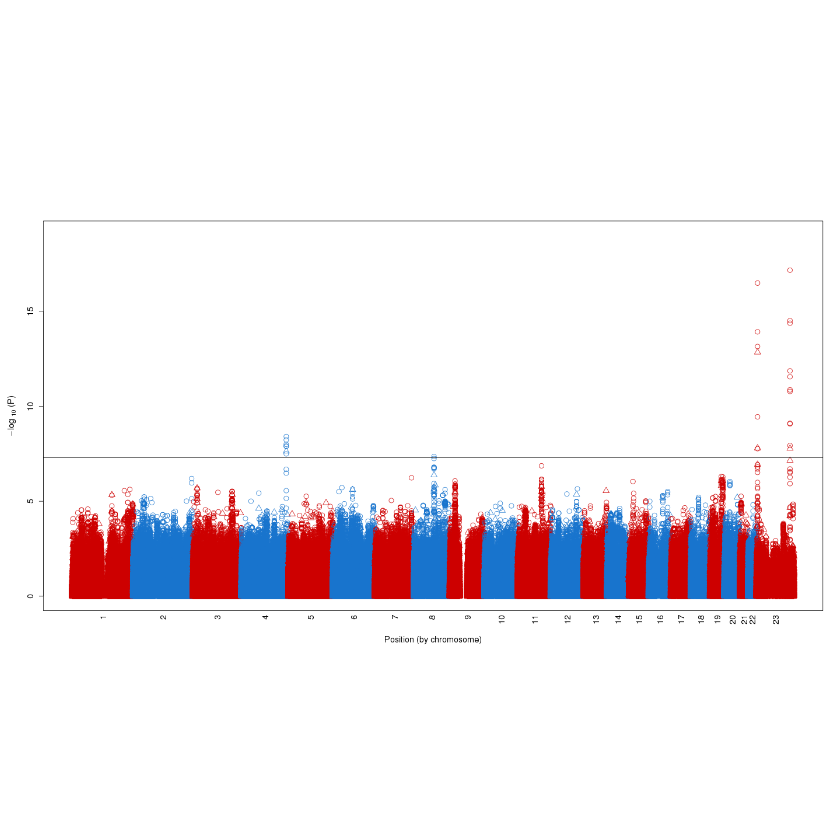

In [58]:
library("png")
library("raster")

man <- readPNG("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/gwas/ea/1df/uhs1234.ea.1df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")
qq <- readPNG("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/gwas/ea/1df/uhs1234.ea.1df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")
grid::grid.raster(man)
#man <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/gwas/ea/1df/uhs1234.ea.1df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png"
#qq <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/gwas/ea/1df/uhs1234.ea.1df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png"
#plot(0:2, 0:2, type = "n", xaxt = "n", yaxt = "n", xlab = "", ylab = "")
#rasterImage(readPNG(source=man), 0, 1, 1, 2)
#rasterImage(readPNG(source=qq), 0, 0, 1, 1)
#rasterImage(readPNG(source=man), 0, 0, 1, 1)
#rasterImage(readPNG(source=qq), 1, 0, 2, 1)

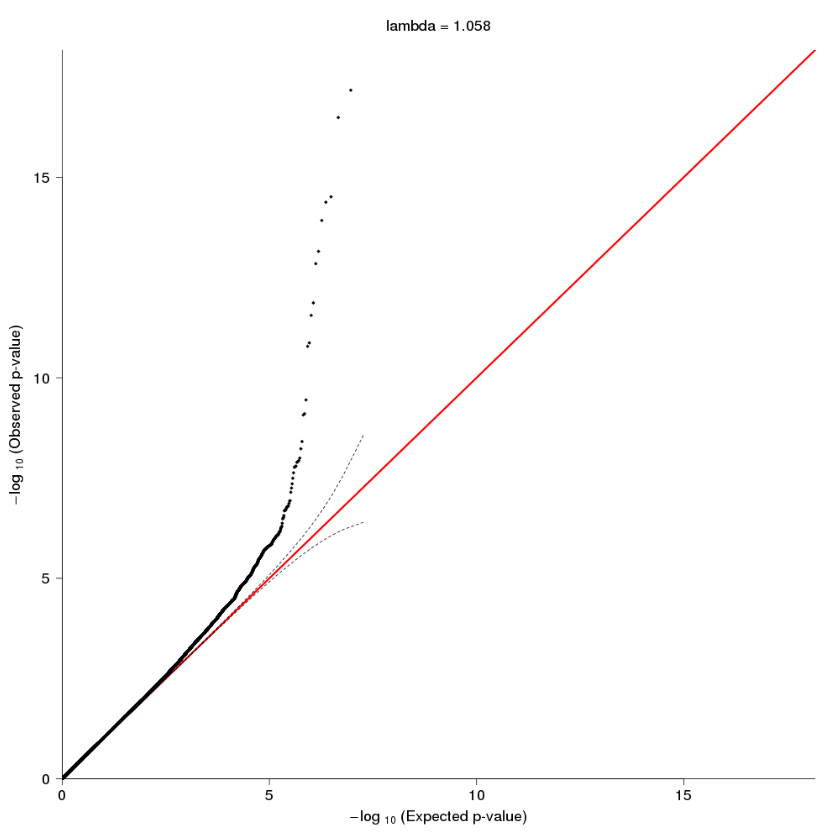

In [2]:
grid::grid.raster(qq)

#### AA 1df

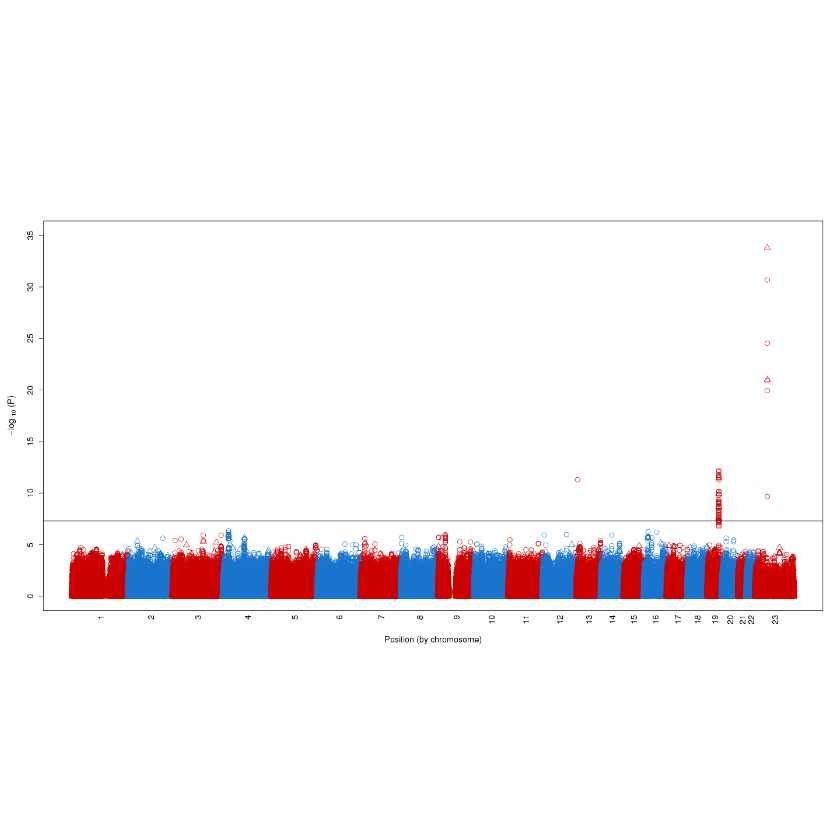

In [60]:
library("png")
man <- readPNG("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/gwas/aa/1df/uhs1234.aa.1df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")
qq <- readPNG("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/uhs1-4/gwas/aa/1df/uhs1234.aa.1df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")
grid::grid.raster(man)

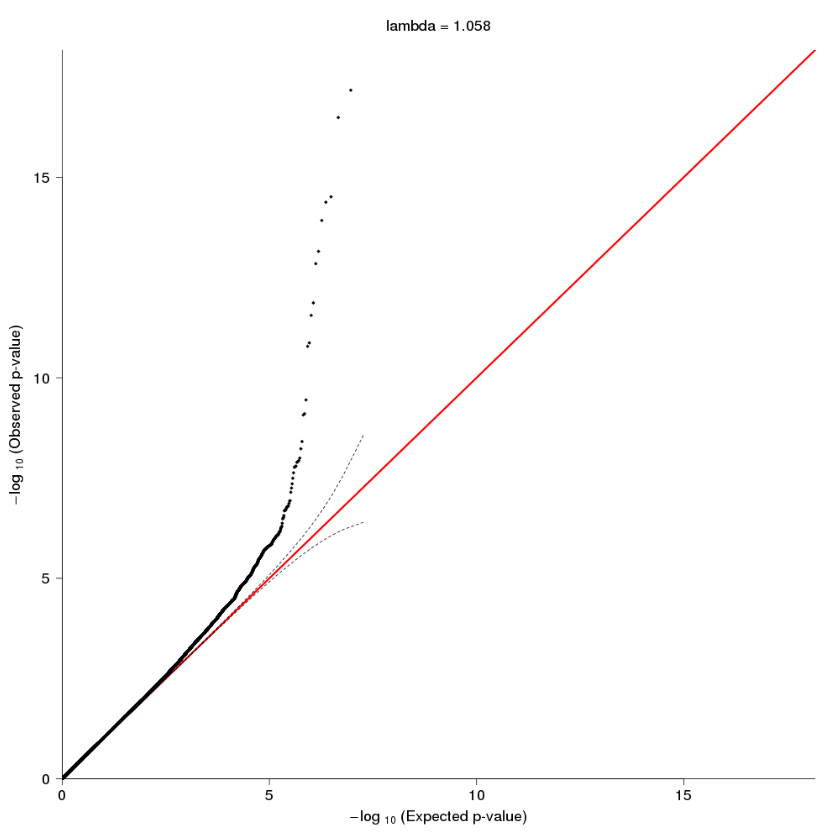

In [59]:
grid::grid.raster(qq)

In [ ]:
## Sort in R ##
R
finalD <- "/shared/jmarks/hiv/uhs1234/gwas/ea/1df/001/processing/"
pfile <- ".maf_gt_0.01_subject+eur.rsq_gt_0.30.p_lte_0.001"

for (ancestry in c("ea")){
    if (ancestry == "aa") { group = "afr" } else if (ancestry == "ea") { group = "eur" }
        dat=read.table(paste0(finalD, pfile), header = TRUE)
        dat <- dat[order(dat$p),]
        write.csv(dat,
                  file=paste0(finalD, pfile, ".csv"), row.names = FALSE, quote=F)
    }
## END Filter by p-value ###

## EA G$\times$Sex GWAS (2df)
**Note1**:  7 individuals removed that had sex discrepancies. See [GitHub issue #42](https://github.com/RTIInternational/bioinformatics/issues/42#issuecomment-465608600).

```
8005964966_NA0054149_93-0143
8005964978_NA0054150_93-0144
8015124413_NA0055272_93-0623
8015124401_NA0055273_93-0624
8015124354_NA0055285_93-0628
8005965380_NA0055556_93-0720
8005964955_NA0056463_93-1068
```

In [ ]:
version="002"
model="2df"
study="vidus"
probabel="palogist"
dose_suffix="mach.dose.filtered"
info_suffix="mach.pruned.info"
covars="sex,age,PC1,PC5,PC9"
MODEL=HIV_ACQ~SNP+SNP*SEX+AGE+SEX+PC1+PC5+PC9
ancestry="ea"
phenoF="vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.txt"
phenoXF="vidus.ea.HIV_ACQ.AGE.SEX.PC1+PC5+PC9.ordered.chrx.txt"
genD=/shared/jmarks/hiv/$study/genotype/impute/final/$ancestry/mach
phenD=/shared/jmarks/hiv/$study/phenotype/final
procD=/shared/jmarks/hiv/$study/gwas/$ancestry/$model/$version
baseDir=$procD/processing

mkdir -p $procD/final
mkdir -p $procD/processing/chr{1..23}
################################################################################


# autosomes
for chr in {22..1}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr${chr}.GxSex.$probabel \
        --script_prefix $procD/processing/chr${chr}/chr${chr}.2df.GxSex.gwas \
        --mem 30 \
        --nslots 7 \
        --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
            --pheno $phenD/$phenoF \
            --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
            --info $genD/chr${chr}/chr${chr}.${info_suffix} \
            --map $genD/chr${chr}/map.chr${chr}.legend \
            --chrom ${chr} \
            --interaction 2 \
            --out $procD/processing/chr${chr}/chr${chr}.GxSex.$probabel.results
done


# chrX
# chrx has a different order phenotype file because the dose file is ordered by sex
chr=23
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name chr${chr}.GxSex.$probabel \
    --script_prefix $procD/processing/chr${chr}/chr${chr}.2df.GxSex.gwas \
    --mem 30 \
    --nslots 7 \
    --program time /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
        --pheno $phenD/$phenoXF \
        --dose $genD/chr${chr}/chr$chr.${dose_suffix} \
        --info $genD/chr${chr}/chr${chr}.${info_suffix} \
        --map $genD/chr${chr}/map.chr${chr}.legend \
        --chrom ${chr} \
        --interaction 2 \
        --out $procD/processing/chr${chr}/chr${chr}.GxSex.$probabel.results

In [ ]:
## check for completion
grep -L 100.00% $procD/processing/chr*/*log

### Results Processing
#### Calculate chi, P, and OR

```
name A1 A2 Freq1 MAF Quality Rsq n Mean_predictor_allele chrom position beta_SNP_addA1 sebeta_SNP_addA1 beta_SNP_SEX sebeta_SNP_SEX cov_SNP_int_SNP_SEX chi2_SNP_add
```

In [ ]:
fileIn <- "tmp"
interactionCovar <- "SEX"
fileOut<- "chr22.interactive.test"

cat("Reading ", fileIn, "...\n", sep="")
dataTable = read.table(fileIn, header = TRUE, na.strings = c("nan","NA", "NaN"))
cat("Calculating...\n")
dataTable = dataTable[complete.cases(dataTable$beta_SNP_addA1),]
for (i in 1:nrow(dataTable)) {
        beta = c(dataTable[i,"beta_SNP_addA1"],dataTable[i,paste("beta_SNP_",interactionCovar,sep="")])
        sigm = matrix(c(dataTable[i,"sebeta_SNP_addA1"]^2,dataTable[i,paste("cov_SNP_int_SNP_",interactionCovar,sep="")],dataTable[i,paste("cov_SNP_int_SNP_",interactionCovar,sep="")],dataTable[i,paste("sebeta_SNP_",interactionCovar,sep="")]^2),2,2)
  sigmSolved = try(solve(sigm),silent=TRUE)

  if (is.matrix(sigmSolved)) {
                dataTable[i,"chi_2df"] = t(beta) %*% sigmSolved %*% beta
                dataTable[i,"p_2df"] = 1 - pchisq(dataTable[i,"chi_2df"],2)
  } else {
                dataTable[i,"chi_2df"] = NA
                dataTable[i,"p_2df"] = NA
        }
}
dataTable = dataTable[complete.cases(dataTable$p_2df),]

if ("chrom" %in% colnames(dataTable) & "position" %in% colnames(dataTable)) {
        dataTable = cbind(subset(dataTable,select=c(name,chrom,position)),subset(dataTable,select=-c(name,chrom,position)))
} else if ("chrom" %in% colnames(dataTable)) {
        dataTable = cbind(subset(dataTable,select=c(name,chrom)),subset(dataTable,select=-c(name,chrom)))
} else if ("position" %in% colnames(dataTable)) {
        dataTable = cbind(subset(dataTable,select=c(name,position)),subset(dataTable,select=-c(name,position)))
}

cat("Writing ", fileOut, "...\n", sep="")
write.table(dataTable, file = fileOut, row.names = FALSE, quote=FALSE)

cat("Done\n")

In [ ]:
#for (( chr=1; chr<24; chr++ )); do
#    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
#        --job_name ea_$chr \
#        --script_prefix $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
#        --mem 15 \
#        --nslots 3 \
#        --priority 0 \
#        --program Rscript ~/bin/calculate_stats_for_probabel_results.R \
#            --in_file $baseDir/chr$chr/chr$chr.GxSex.palogist.results_add.out.txt \
#            --out_file $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
#            --complete
#done

for chr in {22..1};do
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.$ancestry.chr$chr.2df.pvalue.calculation \
        --script_prefix $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
        --mem 13 \
        --nslots 3 \
        --priority 0 \
        --program Rscript ~/bin/calculate_2df_stats_from_probabel_results.R \ \
            --in $baseDir/chr$chr/chr$chr.GxSex.${probabel}.results_add.out.txt \
            --out $baseDir/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
            --interaction_covar SEX
done

Rscript ~/bin/calculate_2df_stats_from_probabel_results.R \  \
            --in tmp \
            --out tmp.out \
            --interaction_covar SEX

In [ ]:
## check for completion
grep -L "Done" chr*/${study}*log

#### calculate chrX MAF

In [ ]:
chrxD=$baseDir/chr23

femaleN=$(awk '$4==1' $phenD/$phenoXF | wc -l)
maleN=$(awk '$4==0' $phenD/$phenoXF | wc -l)

## calculate new MAF using by recalculating the combined sex specific stats
# first get overlapping SNPs 
# note that I have the info file in the processing dir
cut -f1 <(tail -n +2 $chrxD/chrX.no.auto_female.info) | sort >\
   $chrxD/female_SNPs 
cut -f1 <(tail -n +2 $chrxD/chrX.no.auto_male.info) | sort >\
   $chrxD/male_SNPs 

comm -12 $chrxD/male_SNPs $chrxD/female_SNPs >\
    $chrxD/snp.intersection

# filter info file to the interction
head -1 $chrxD/chrX.no.auto_female.info > $chrxD/female.intersection.info
head -1 $chrxD/chrX.no.auto_male.info > $chrxD/male.intersection.info
awk 'NR==FNR{map[$1]=$1; next} { if ($1 in map) {print $0} }' \
    $chrxD/snp.intersection $chrxD/chrX.no.auto_female.info >>\
    $chrxD/female.intersection.info 

awk 'NR==FNR{map[$1]=$1; next} { if ($1 in map) {print $0} }' \
    $chrxD/snp.intersection $chrxD/chrX.no.auto_male.info >>\
    $chrxD/male.intersection.info 

# Calculate new merged MAF
awk -v fN=$femaleN -v mN=$maleN 'NR==FNR{female[$1] = $5; next} 
    FNR>=2{$5 = ( female[$1]*fN + $5*mN ) / (fN + mN)}
    {print $0}' $chrxD/female.intersection.info $chrxD/male.intersection.info >\
    $chrxD/merged.info

# insert recalculated MAF into stats file and filter to intersection
head -1 $chrxD/$study.$ancestry.1000G_p3.chr23.$MODEL.stats > \
    $chrxD/$study.$ancestry.1000G_p3.chr23.$MODEL.recalc_maf.stats
awk 'FNR==NR{map[$1]=$5; next} 
    { if ($1 in map) 
    {$7= map[$1]; print $0 } }'  $chrxD/merged.info \
    $chrxD/$study.$ancestry.1000G_p3.chr23.$MODEL.stats >> \
    $chrxD/$study.$ancestry.1000G_p3.chr23.$MODEL.recalc_maf.stats

#### convert name to 1000G_p3

In [ ]:
for chr in {1..22};do
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name vidus_1000g_p3_chr${chr}_name \
        --script_prefix ${baseDir}/chr$chr/name_conversion \
        --mem 15 \
        --nslots 3 \
        --priority 0 \
        --program time perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
            --file_in ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats \
            --file_out ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
            --file_in_header 1 \
            --file_in_id_col  0 \
            --file_in_chr_col  1 \
            --file_in_pos_col  2 \
            --file_in_a1_col  3 \
            --file_in_a2_col  4 \
            --chr $chr
done

chr=23
bash /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name $study.1000g_p3.chr${chr}.name.conversion \
    --script_prefix $chrxD/name_conversion \
    --mem 15 \
    --nslots 1 \
    --priority 0 \
    --program perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in $chrxD/$study.$ancestry.1000G_p3.chr$chr.$MODEL.recalc_maf.stats \
        --file_out $chrxD/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
        --file_in_header 1 \
        --file_in_id_col  0 \
        --file_in_chr_col  1 \
        --file_in_pos_col  2 \
        --file_in_a1_col  3 \
        --file_in_a2_col  4 \
        --chr $chr

In [ ]:
## check for completion
grep -L "Done" ${baseDir}/chr*/name*log

### Filter results
MAF filters in study and 1000G, as well as imputation quality (r^2) filter.

**Note**, according to Fang Fang, when you convert the dosage file from vcf to mach, the info files from male/female are not accurate for variants in terms of AF and quality, so I did not use info file in Dosage_Converter. Instead I calculated these AF after GWAS by taking into account both the male and female AFs. The quality score I reported in both genders.
#### MAF > 0.01 in Study

In [ ]:
## EC2 console ##

# Filter MAF <= 0.01 in subjects
#for ancestry in ea aa; do
ancestry=ea
    for ((chr=1; chr<24; chr++));do
        echo "Processing chr${chr}_${ancestry}"
        head -n 1 ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted > \
            ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats

        # note column 7 corresponds to the MAF column
        awk ' NR>=2 {if ($7 >= 0.01) {print $0}}' \
            ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.stats.converted \
            >> ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats
    done 
#done

#### MAF > 0.01 in 1000G

In [ ]:
if [ $ancestry == "aa" ]; then
    group=afr
elif [ $ancestry == "ea" ]; then
    group=eur
fi

# creating a list of SNPs based off of 1000G population 
# - filter the variants to ones whose MAF <= 1%
for chr in {1..22};do
    echo "Processing chr$chr"
   awk ' { if ($9 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz) >\
    /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}
done 

# chrX
chr=23
awk ' { if ($9 >= 0.01) {print $1}}' <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz) >\
    /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}


for chr in {1..23}; do
    idList=/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group} 
    echo "Processing chr${chr}_${ancestry}"      
    /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
        --source ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats \
        --id_list $idList \
        --out ${baseDir}/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats \
        --header 1 \
        --id_column 0 
done 

#### RSQ >= 0.30

In [ ]:
## Filter by R^2 Autosomes
for chr in {1..22}; do
    echo -e "${ancestry} chr${chr}..."
        awk '{ if ($9 > 0.3){ print $0 } }' \
            $procD/processing/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.stats >\
             $procD/final/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats
done


## Filter by R^2 chrX
# chrX note that imputed data are split up by males & females 
# perform the filtering on both male and female data and then merge results
chr=23
echo -e "${ancestry} chr${chr}..."
tail -n +2 $chrxD/chrX.no.auto_male.info| \
    awk '{ if( $7 > 0.3){ print $1":"$2":"$3 } }' \
    > $procD/processing/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp

tail -n +2 $chrxD/chrX.no.auto_female.info| \
    awk '{ if( $7 > 0.3){ print $1":"$2":"$3 } }' \
    >> $procD/processing/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp

## keep only SNPs that passed filters for both males and females
sort $procD/processing/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp |\
    uniq -d > $procD/processing/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep 

# change X to 23
awk -F":" '$1=23 {print $0}' $procD/processing/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep >\
    $procD/processing/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep.split

# filter results
awk ' NR==FNR { map[$1":"$2":"$3":"$4] = 1; next}
    FNR==1 {print $0}
    FNR>=2 {if  (map[$2":"$3":"$4":"$5] == 1)
    { print $0} }' *keep.split \
    vidus.ea.1000G_p3.chr23.$MODEL.maf_gt_0.01_subject+eur.stats >\
    $procD/processing/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats

cp $procD/processing/chr$chr/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats \
    $procD/final

### Plot results

In [ ]:
group=eur
if [ $model == "1df" ]; then
    pcol=10
else
    pcol=13
fi

outfile=$procD/processing/${study}.${ancestry}.$model.1000G_p3.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
for (( chr=1; chr<24; chr++ )); do
infile=$procD/final/$study.ea.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
echo Processing $infile
tail -n +2 $infile |
  perl -slne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){13}\s+(\S+)/;
              if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                print join("\t",$1,$2,$3,$6,"snp");
              } else {
                print join("\t",$1,$2,$3,$6,"indel");
              }' -- -pcol >> $outfile
done &


# Make Q-Q and manhattan plots
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix $procD/final/${ancestry}.$model.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot \
    --mem 20 \
    --nslots 7 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $procD/processing/$study.$ancestry.$model.1000G_p3.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $procD/final/$study.${ancestry}.$model.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda


In [ ]:
## Get list of variants to filter by imputation quality and MAF
for chr in {1..22}; do
    echo -e "${ancestry} chr${chr}..."
    zcat $genD/chr${chr}.info.gz | \
        tail -n +2 | \
        awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
        > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep
done

# chrX note that imputed data are split up by males & females (229F 709M)
# perform the filtering on both male and female data and then merge results
chr=23
echo -e "${ancestry} chr${chr}..."
zcat $genD/chrx/chrX.no.auto_male.info.gz | \
    tail -n +2 | \
    awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
    > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp

echo -e "${ancestry} chr${chr}..."
zcat $genD/chrx/chrX.no.auto_female.info.gz | \
    tail -n +2 | \
    awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
    >> $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp

# keep only SNPs that passed filters for both males and females
sort $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep.tmp |\
    uniq -d > $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep



# Filter results files
if [ $ancestry == "aa" ]; then
    pop=AFR
else
    pop=EUR
fi
for chr in {1..23}; do
    if [ $chr == 23 ]; then
        tchr="X"
    else
        tchr=$chr
    fi

    echo "processing $ancestry chr${chr}..."
    awk '{ if(NR==FNR){ map[$1]=1; next } { if(map[$1":"$2":"$3":"$4]==1){ print $0 } } }' \
        $procD/processing/chr$chr/${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
        <(zgrep -P "^${tchr}\s" $procD/processing/chr$chr/${study}.${pop}.1000G.oaall.chr${chr}.MetaScore.assoc.gz) \
        > $procD/processing/chr$chr/${study}.${ancestry}.1000G.oaall.chr${chr}.tmp
done &
cat $procD/processing/chr*/${study}.${ancestry}.1000G.oaall.chr*tmp | gzip -c > $procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz

# cleanup
#rm $procD/processing/chr*/*tmp 


# Make results table
outfile=$procD/processing/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
infile=$procD/final/${study}.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.gz
echo "Processing ${infile}"
zcat ${infile} | \
    perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                } else {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                }' >> $outfile


# convert chrX to chr23 in this table
awk '{if ($2=="X") {$2="23"; gsub("X", "23", $1)}} {print $0}' \
    vidus.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table >\
    tmp && mv tmp vidus.ea.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table


# Make Q-Q and manhattan plots
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix $procD/final/${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot \
    --mem 30 \
    --nslots 7 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $procD/processing/$study.$ancestry.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $procD/final/$study.${ancestry}.1000G.oaall.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda

####   SNP lookup (EA)
Eric O. Johnson requested a lookup of rs4878712—a SNP reported in a prior paper whose G allele reduces the risk of HIV. This SNP's position is 37654257 in the GRCh37 build.

### View plots
#### EA
```
![vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png](attachment:vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png)
![vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png](attachment:vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png)
```

In [ ]:
library("IRdisplay")
library("png")
#display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/2df/20190429/vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")  
#display_png(file="C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/2df/20190429/vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")  
man <- readPNG('C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/2df/20190429/vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png')
qq <- readPNG('C:/Users/jmarks/OneDrive - Research Triangle Institute//Projects/HIV/vidus/gwas/probabel/2df/20190429/vidus.ea.2df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png')
grid::grid.raster(man)

In [ ]:
grid::grid.raster(qq)

### P-value Filter

In [ ]:
group=eur
if [ $model == "1df" ]; then
    pcol=10
else
    pcol=13
fi

outFile=$procD/final/$study.$ancestry.1000G_p3.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.p_lte_0.001
head -n 1 $procD/final/$study.$ancestry.1000G_p3.chr22.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats > $outFile
for (( chr=1; chr<24; chr++ )); do
chr=23
    echo Processing $procD/final/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats
    tail -n +2 $procD/final/$study.$ancestry.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+eur.rsq_gt_0.30.stats |\
    perl -lane 'if ($F[18] <= 0.001) { print; }' >>  $outFile
done


In [ ]:
## Sort in R ##
R
cohort="uhs1234"
finalD <- "/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/1df/ea/001/final/"
pfile <- "uhs1234.ea.1df.1000G_p3.HIV_ACQ~SNP+AGE+SEX+PC1+PC9+PC10.maf_gt_0.01_subject+eur.rsq_gt_0.30.p_lte_0.001"

for (ancestry in c("ea")){
    if (ancestry == "aa") { group = "afr" } else if (ancestry == "ea") { group = "eur" }
        dat=read.table(paste0(finalD, pfile), header = TRUE)
        dat <- dat[order(dat$p),]
        #dat <- dat[order(dat$p2df),]
        write.csv(dat,
                  file=paste0(finalD, pfile, ".csv"), row.names = FALSE, quote=F)
    }
## END Filter by p-value ###

In [ ]:
## Sort in R ##
R
cohort="uhs1234"
finalD <- "/shared/jmarks/hiv/uhs1234/acquisition_gwas/gwas/2df/ea/001/final/"
pfile <- "uhs1234.ea.2df.1000G_p3.HIV_ACQ~SNP+AGE+SEX+SNPbySEX+PC1+PC9+PC10.maf_gt_0.01_subject+eur.rsq_gt_0.30.p_lte_0.001"

for (ancestry in c("ea")){
    if (ancestry == "aa") { group = "afr" } else if (ancestry == "ea") { group = "eur" }
        dat=read.table(paste0(finalD, pfile), header = TRUE)
        #dat <- dat[order(dat$p),]
        dat <- dat[order(dat$p_2df),]
        write.csv(dat,
                  file=paste0(finalD, pfile, ".csv"), row.names = FALSE, quote=F)
    }
## END Filter by p-value ###

# README
```css
Author: Jesse Marks
Date: 20190429

Software: ProbABEL
Cohort: VIDUS
Ancestry: EA
N Samples: 931
Description: GxSEX GWAS (2df)
             HIV acquisition
             7 sex discrepant subjects removed
Model: HIV_ACQ ~ SNP + SNP*SEX + sex + age + PC1 + PC5 + PC9

Note, we updated this 2df GWAS because the 2df P-value calculation was not calculated last go-round. We erroneously used a 1df calculation.
```

# Upload results to S3

In [ ]:
cd /shared/jmarks/hiv/vidus/gwas/ea/2df/002
aws s3 sync . s3://rti-hiv/vidus/results/2df --quiet &

# Sandbox

In [ ]:
#!/bin/bash

anlist="ea aa" # "ea", "aa", or "ea aa"
study="uhs1234"
case_control="true"
genoD="/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/observed"
procD="/shared/jmarks/hiv/uhs1234/acquisition_gwas/test"
eig="$procD/eig"
mkdir -p $eig/results

# rename phenotype file(s)
for an in $anlist;do
    cp $procD/uhs1234_${an}_phenotype_table_clean.txt \
        $procD/$study_${an}_phenotype_for_pca.txt
done


## generate new set of genotype data ##
for an in $anlist;do
    genotype_file="${an}_studies_merged"
    awk 'NR>=2{print $1,$1}' $procD/uhs1234_${an}_phenotype_table_clean.txt > \
        $procD/$study.$an.final_ids

    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $genoD/$an/$genotype_file \
        --keep $procD/$study.$an.final_ids \
        --make-bed \
        --out $eig/$study.$an.genotypes
done


# Do not edit below this line
################################################################################
################################################################################

## Remove high-LD region variants ##
for an in $anlist; do
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
        $eig/$study.$an.genotypes.bim > $eig/$study.$an.genotypes.high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes \
        --exclude $eig/$study.$an.genotypes.high_ld_regions.remove \
        --make-bed \
        --out $eig/$study.$an.genotypes.high_ld_regions_removed
done


## Linkage disequilibrium pruning ##
for an in $anlist;do
    for chr in {1..22}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out $eig/${an}_chr${chr}_ld_pruned
    done
done

# Merge *prune.in files
for an in $anlist; do
    cat $eig/${an}_chr*_ld_pruned.prune.in > $eig/${an}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes.high_ld_regions_removed \
        --extract $eig/${an}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/$study.$an.genotypes.ld_pruned
done

# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*ld_prune*qsub*
rm $eig/*high_ld_regions*
rm $eig/*nosex


## Rename BIM/FAM file IDs
for an in $anlist;do
    # Rename FAM file IDs
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.fam \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.fam

    # Rename BIM file IDs
    awk '{$2="ID_"NR; print $0}' $eig/$study.$an.genotypes.ld_pruned.bim \
        > $eig/$study.$an.genotypes.ld_pruned_renamed.bim
done

## Assign Case/Control to FAM file if applicable
if [ $case_control == "true" ]; then
    for an in $anlist; do
        pfile=$procD/$study_${an}_phenotype_for_pca.txt

        ## extract the IDs of controls 
        tail -n +2 $pfile |\
            awk '{ if ($2==0) {print $1}}' > $eig/$an.controls.ids

        # Modify FAM file to include case/control status
        awk 'NR==FNR{map[$1] = $1; next} {if($2 in map) {$6=1} else {$6=2}} {print $0} ' \
            $eig/$an.controls.ids $eig/$study.$an.genotypes.ld_pruned_renamed.fam >\
            $eig/$study.$an.genotypes.ld_pruned_renamed_case_control.fam
    done
fi

## run eigenstrat ##
for an in $anlist; do
    if [ $case_control == "true" ]; then
        famfile="$eig/$study.$an.genotypes.ld_pruned_renamed_case_control.fam"
    else
        famfile="$eig/$study.$an.genotypes.ld_pruned_renamed.fam"
    fi
    bimfile="$eig/$study.$an.genotypes.ld_pruned_renamed.bim"
    bedfile="$eig/$study.$an.genotypes.ld_pruned.bed"

    /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i $bedfile \
        -a $bimfile \
        -b $famfile \
        -o $eig/results/${an}_ld_pruned.pca \
        -p $eig/results/${an}_ld_pruned.plot \
        -e $eig/results/${ancestry}_ld_pruned.eval \
        -l $eig/results/${ancestry}_ld_pruned.pca.log \
        -m 0
done


for an in $anlist; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${an}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
done


## Rscript produce the PCA plots
# Rscript myRscript

In [ ]:
study=uhs1234
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name $study.smartpca \
    --script_prefix ${study}_smartpca \
    --mem 3 \
    --nslots 2 \
    --program time bash _methods_${study}_pca.sh

/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name hic_download \
    --script_prefix hic_download \
    --mem 3 \
    --nslots 2 \
    --program time bash hic_download.sh

In [ ]:
scp -vr scacherip-1945@scp.nygenome.org:/data/delivery/scacherip-1945/data/Project_AKB_13942_B01_NAN_Lane.2019-04-24 .

In [ ]:
create_pedfile <- function(phen_file, pca_file, phenotype, sex_var, covariates, study, ancestry){
    
    # phenotype file
    pheno_data <- read.delim(phen_file, sep="")
    pca_data <- read.delim(pca_file, sep="")
    other_pedcols <- c("fid", "iid", "patid", "matid", sex_var)
    ped_width <- length(other_pedcols) + length(phenotype)
    ped_length <- nrow(pheno_data)
    ped_file <- data.frame(matrix(ncol=ped_width, nrow=ped_length))
    colnames(ped_file) <- c(other_pedcols, phenotype)
    ped_file[phenotype] <- pheno_data[phenotype]
    ped_file[sex_var] <- pheno_data[sex_var]
    ped_file["fid"] <- pheno_data[1]
    ped_file["iid"] <- pheno_data[1]
    # covariate file
    num_cols <- 14 + length(covs)
    covar_data <- data.frame(matrix(ncol=num_cols, nrow=ped_length))
    colnames(covar_data) <- c("fid", "iid", "patid", "matid", covs,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    covar_data[,1:4] <- ped_file[, 1:4]
    for (i in covs){
        covar_data[,i] <- pheno_data[,i]
    }
    
    covar_data[, (num_cols-9):num_cols] <- pca_data[,3:12]
    write.table(ped_file, paste(study,"_", ancestry, "_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)
    write.table(covar_data, paste(study,"_", ancestry, "_cov.ped", sep=""), sep = "\t", row.names = F, quote=F)
    head(ped_file)
    #head(covar_data)
    
    } # end function


regression_analysis <- function(cov_file, phen_file, phenotype_name, model_type, ancestry){
    options(stringsAsFactors=F)
    
    cov_data <- read.delim(cov_file, sep="")
    phen_data <- read.delim(phen_file, sep="")
    pc_names <- paste0("PC", 1:10)
    merge_data <- merge(x=phen_data[,c("iid", phenotype_name)], y=cov_data[, c("iid", pc_names)], by="iid")
    
    model.str <- paste0(phenotype_name, "~", paste(pc_names, collapse=" + ")) 
    cat("MODEL FORMULA:\n\n", model.str, "\n")
    
    # Get model fits
    if (model_type=="continuous"){
        model_fit <- lm(formula=as.formula(model.str), data=merge_data)
        pve_calc <- "Mean Sq"
    }
    else if (model_type=="logistic"){
        model_fit <- glm(formula=as.formula(model.str), data=merge_data, family=binomial(link="logit"))
        pve_calc <- "Deviance"
    }
    
    # Get sequential (type I) sum of squares
    anova_model <- anova(model_fit)
    
    # Calculate percent variance explained and sort
    variance_explained <- cbind(anova_model[pc_names,], 
                    PVE=round(anova_model[pc_names, pve_calc]/sum(anova_model[pc_names, pve_calc])*100, digits=2))
    pve_sorted <- variance_explained[order(variance_explained$PVE, decreasing=T),]
    
    # Output regression info
    cat(paste("\n\n================", ancestry,  "group ================\n"))
    summary(model_fit)
    pve_sorted
    
    # Percent Variance Explained Visualization
    options(repr.plot.width=13, repr.plot.height=5)

    # Set graphical parameters
    cex.factor <- 1.1
    barplot_ylim <- c(0, max(variance_explained$PVE)*1.2)

    pv_list <- vector(length = 10)
    total <- 0
    for (i in 1:nrow(pve_sorted)){
        pv_list[i] <- row.names(pve_sorted[i,])
        total <- total + pve_sorted[i, "PVE"]
        #print(total)
        if (total >= 75) break
    }

    topPCs <- pv_list[which(pv_list != "FALSE")]
    cat("Top PCs: ",topPCs, "\n")
    cat(paste("PVE:     ", total))

    # Visualize PVE
    mywidth=1800
    myheight=800
    jpeg("rplot.jpg", width = mywidth, height = myheight)
    par(mfrow=c(1,2))
    barplot(height=variance_explained$PVE, names.arg=rownames(variance_explained),
            beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, 
            main=paste(ancestry,"Percent Variance Explained"),
            ylab="PVE", cex.main=2, cex.lab=1.1)
    plot(cumsum(variance_explained$PVE), type="b",
         main=paste(ancestry, "PVE Cumulative Sum"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", 
         xlab="", ylim=c(0,100), cex.main=2, cex.lab=1.1)
    axis(side=1, at=c(1:10), labels=rownames(variance_explained),
         cex.axis=cex.factor)
    dev.off()

    jpeg("rplot2.jpg", width = mywidth, height = myheight)
    par(mfrow=c(1,2))
    barplot(height=pve_sorted$PVE, names.arg=rownames(pve_sorted),
            beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim,
            main=paste(ancestry,"Percent Variance Explained (Sorted PCs)"),
            ylab="PVE", cex.main=2, cex.lab=1.1)
    plot(cumsum(pve_sorted$PVE), type="b", 
         main=paste(ancestry,"PVE Cumulative Sum (Sorted PCs)"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100), 
         cex.main=2, cex.lab=1.1)
    axis(side=1, at=c(1:10), labels=rownames(pve_sorted),
         cex.axis=cex.factor)
    dev.off()
}


study <- "UHS1234"
ancestry <- "AFR" # EUR or AFR
phenotype <- "hiv"
sex_var <-  "gender"
covs <- c(sex_var, "age")
phen_file <- "../uhs1234_aa_phenotype_table_clean.txt"
pca_file <- "../eig/results/aa_ld_pruned_top10_eigenvecs.txt"
model_type <- "logistic" # continuous or logistic

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)


In [ ]:
an=aa
    imputedir=/shared/jmarks/hiv/uhs1234/acquisition_gwas/genotype/imputed/$an
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name bmerge \
        --script_prefix ${imputedir}/bmerge \
        --mem 7.5 \
        --nslots 1 \
        --priority 0 \
        --program "/shared/bioinformatics/software/third_party/bcftools-1.6/bcftools merge \
            ${imputedir}/chrX.no.auto_male.dose.vcf.gz ${imputedir}/chrX.no.auto_female.dose.vcf.gz \
            -O z -o ${imputedir}/chrX.no.auto.vcf.gz"
done


In [ ]:
for chr in {1..23};do
    file=hiv_acquisition_1df_meta_analysis_uhs1-4_ea+wihs1_ea.chr$chr.1df
   /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name  gzip2.chr$chr \
        --script_prefix  zip2.c | r$chr\
        --mem 1 \
        --nslots 3 \
        --program gzip $file 
done

